In [295]:
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely.geometry import Point
import math
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
import numpy as np
import math
import time

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Finding the Busiest Road Segment by Routing Trips

One question that we would like to answer is which roads are bikeshare users using?

There are 2 easy ways to analyze this:
   1. We connect the origin and destination of a trip with a straight line, then construct a Kernal Density map. We can then spatially interpolate the "trip activity" each road gets, and convert that to raw trips.
   2. We can use a shortest path algorithm to route trips through the road network, for each origin-destination pair.
   
Method 2 would produce a more real result, that is less abstract, so we'll use this method of finding the busiest road segment from bikeshare users.

## Introduction to `networkx`

We can use a package called `networkx`. `networkx` uses a method called graph or network theory, which is a representation of a network using nodes and links. We can then use a built in shortest path algorithm to find the path a trip takes in the network. 

Below is an example graph that has been randomly created. 

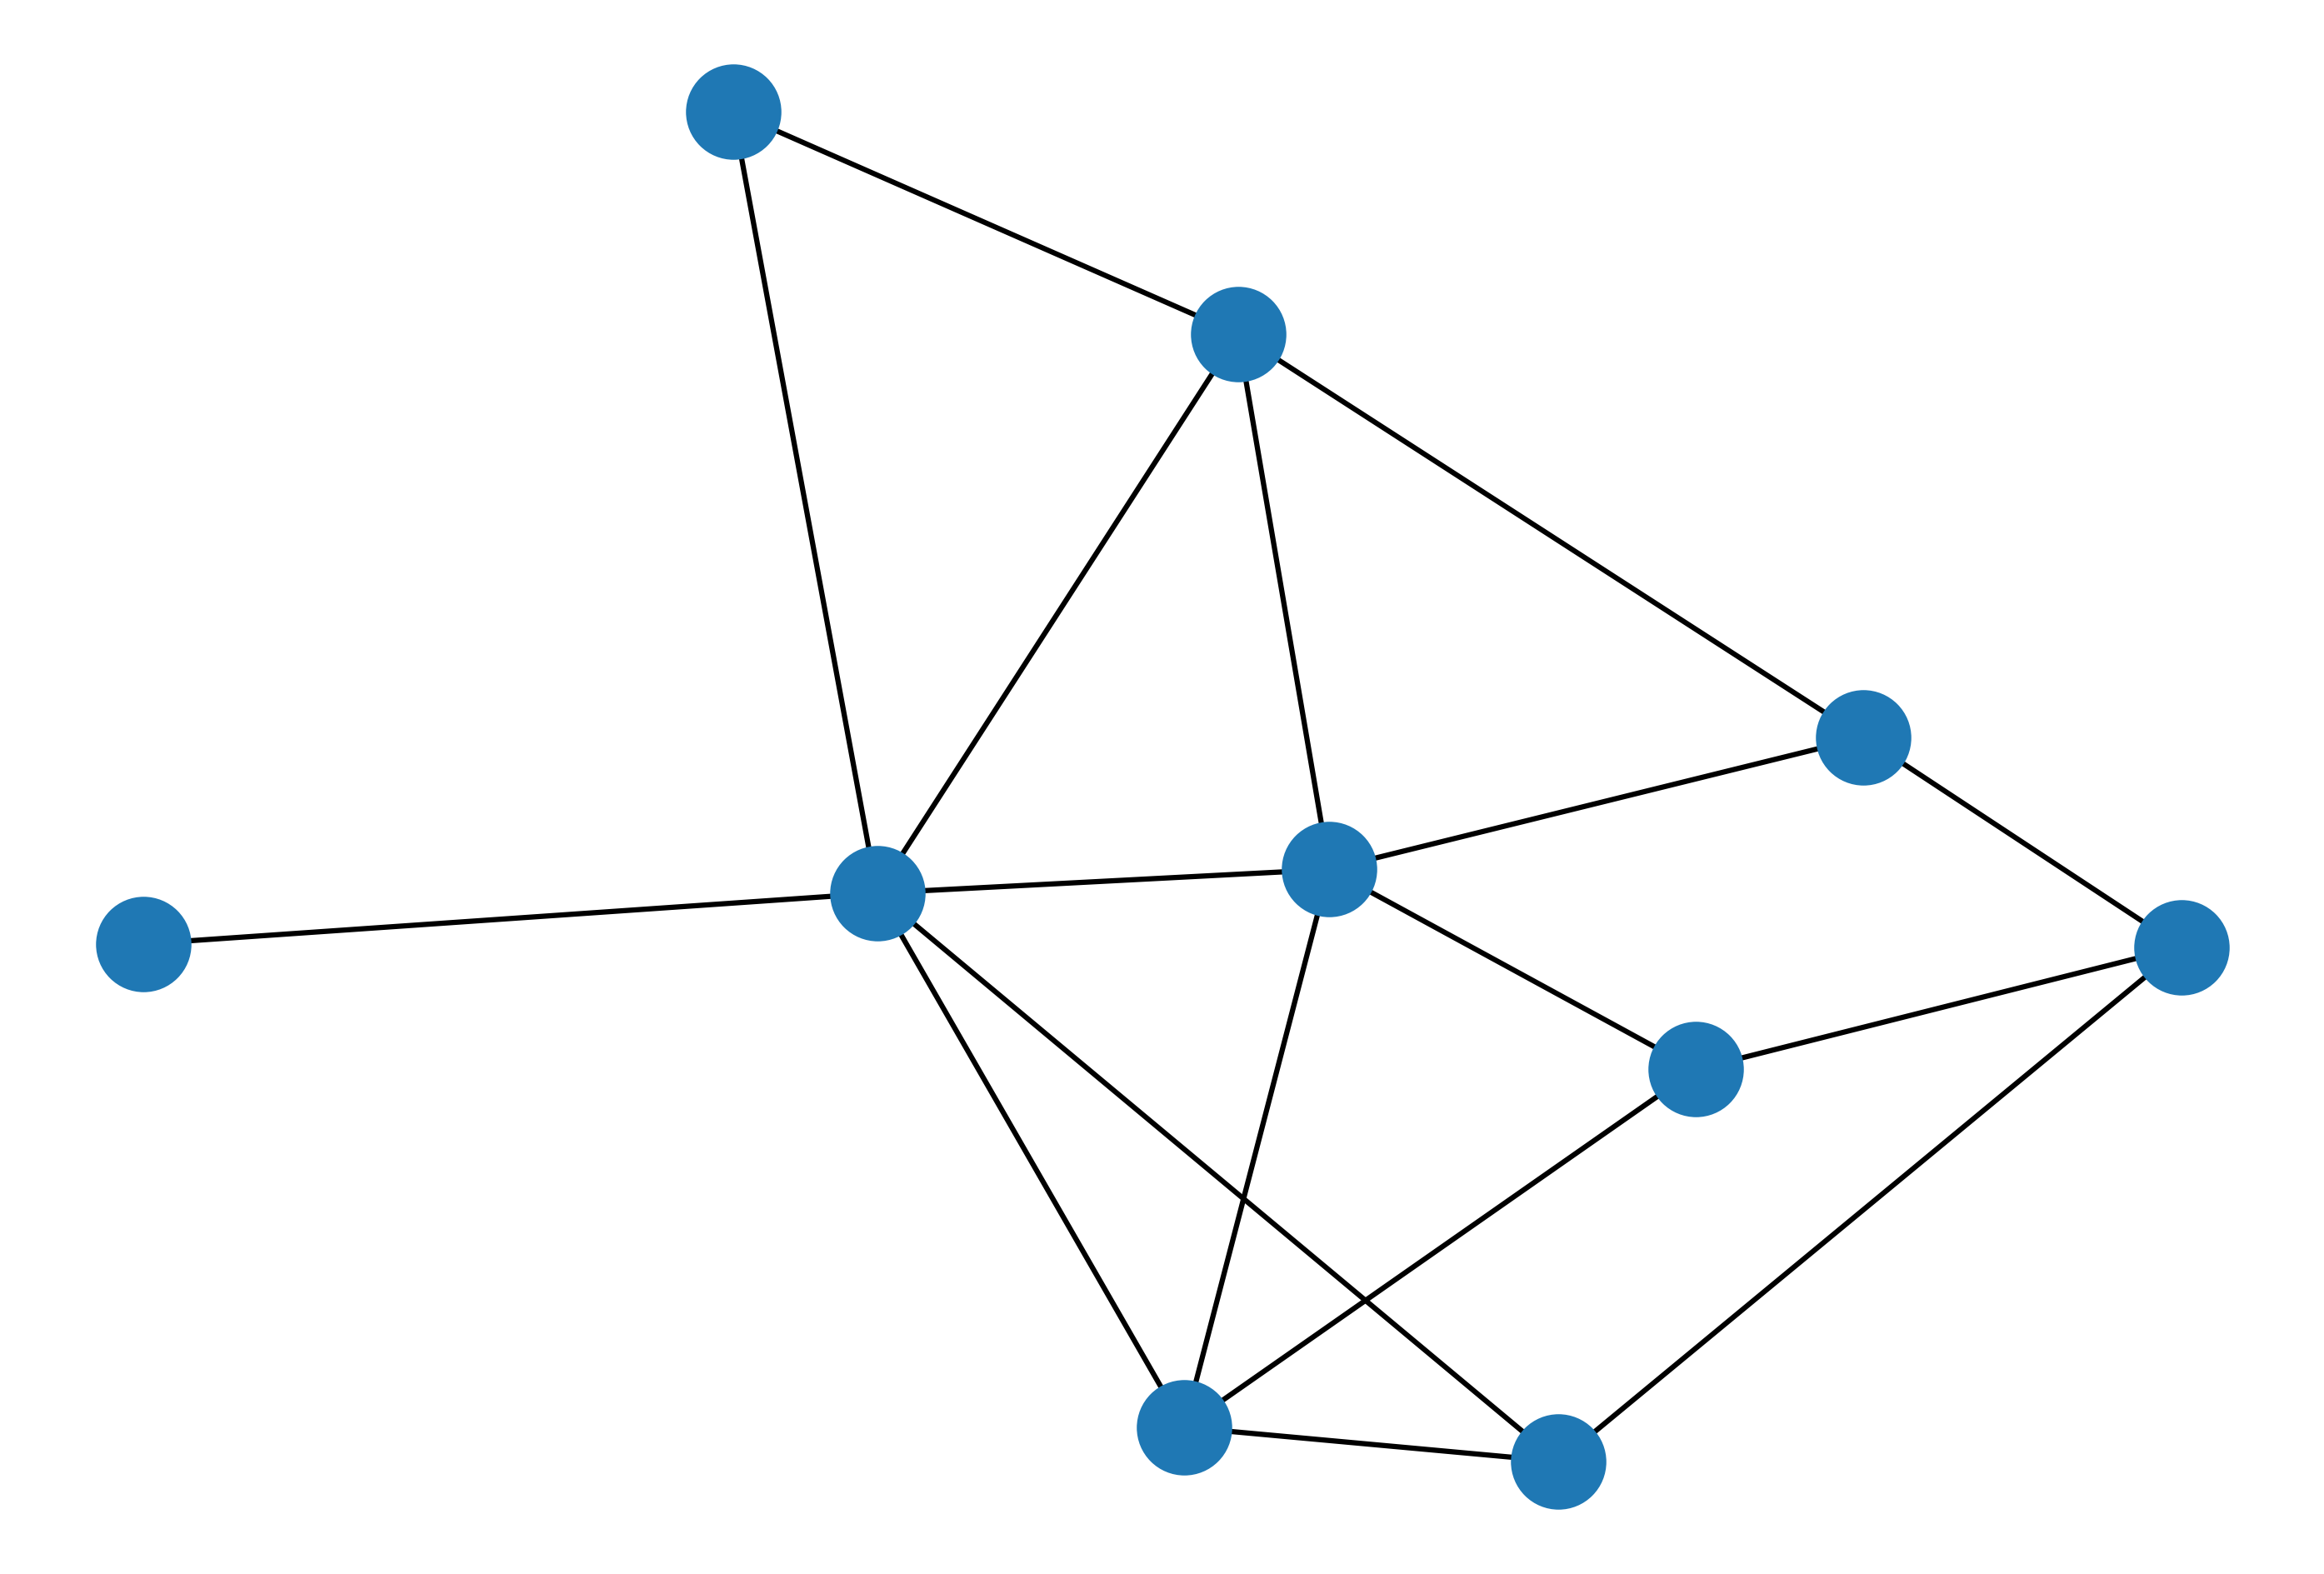

In [393]:
# Create a random graph with 10 graph, and probability an edge exists is 0.4
test = nx.fast_gnp_random_graph(10, 0.4, 0)

nx.draw(test)

## Preparing the Nodes and Links

For our application, the edges/links are the streets/trails, and the nodes are the intersections. 

The City of Toronto has a open data spatial layer, the [centreline](https://open.toronto.ca/dataset/toronto-centreline-tcl/), that contains the individual road segments of the city. Each segment is approximately 100m long, although this greatly varies since it depends on where an intersection is.

The centreline layer is linked directly to the [intersections layer](https://open.toronto.ca/dataset/intersection-file-city-of-toronto/) that the City of Toronto also has on their open data portal. The `FNODE` and `TNODE` columns refer to the `INT_ID` of the intersections.

In [395]:
centreline = gpd.read_file('centreline.geojson')
intersections = gpd.read_file('intersections/CENTRELINE_INTERSECTION_WGS84.shp')

### Preparing the Links

In [396]:
centreline.head()

GEO_ID  LFN_ID           LF_NAME ADDRESS_L ADDRESS_R OE_FLAG_L OE_FLAG_R  \
0   914632    2273         Phlox Ave      2-20      3-21         E         O   
1   914590    1532         Elder Ave     91-91      None         O         N   
2  9109246    2617  Thirty Second St     58-70     57-75         E         O   
3   914605    1532         Elder Ave      None      None         N         N   
4  9109255    2617  Thirty Second St      2-56      1-55         E         O   

   LONUML  HINUML  LONUMR  HINUMR     FNODE     TNODE   FCODE FCODE_DESC  \
0     2.0    20.0     3.0    21.0  13470579  13470553  201500      Local   
1    91.0    91.0     NaN     NaN  13470547  13470554  201400  Collector   
2    58.0    70.0    57.0    75.0  13470563  13470545  201500      Local   
3     NaN     NaN     NaN     NaN  13470554  13470563  201500      Local   
4     2.0    56.0     1.0    55.0  13470618  13470563  201500      Local   

        JURIS_CODE  OBJECTID  SHAPE_LENGTH  \
0  CITY OF TORONTO        31     96.539575   
1  CITY OF TORONTO        40     98.707488   
2  CITY OF TORONTO        41     86.709803   
3  CITY OF TORONTO        42    104.174108   
4  CITY OF TORONTO        43    281.757798   

                                            geometry  
0  LINESTRING (-79.52648 43.59696, -79.52686 43.5...  
1  LINESTRING (-79.52966 43.59804, -79.53082 43.5...  
2  LINESTRING (-79.53205 43.59747, -79.53239 43.5...  
3  LINESTRING (-79.53082 43.59776, -79.53205 43.5...  
4  LINESTRING (-79.53099 43.59506, -79.53205 43.5...

For our analysis, we will use the following columns from the centreline:
* `GEO_ID` - the unique identifier for a segment
* `LFN_ID` and `LFN_NAME` - the identifier and string name of the street
* `FNODE` and `TNODE` - the `INT_ID` that corresponds to the intersections in the intersections layer
* `FCODE_DESC` - the road classification
* `geometry`

In [297]:
centreline = centreline[['GEO_ID', 'LFN_ID', 'LF_NAME', 'FNODE', 'TNODE', 'FCODE_DESC', 'geometry']]

For all the spatial layers, I'll be converting them to `UTM ZONE 17N` projection, and rotating the layer 17 degrees so Toronto is perpendicular with the map boundary.

In [401]:
centreline = centreline.to_crs(epsg = '26917')
for index, row in centreline.iterrows():
    rotated = shapely.affinity.rotate(row['geometry'], angle=-17, origin = Point(0, 0))
    centreline.at[index, 'geometry'] = rotated

The default way for a shortest path algorithm to work is to count the number of links, but we can specify a different weight to find the shortest path. We'll calculate a `length` column (length in meters) for `networkx` to use in its shortest path calculation.

In [299]:
centreline['length'] = centreline.length

Many different road classes exist in the centreline layer.

In [300]:
centreline['FCODE_DESC'].unique()

array(['Local', 'Collector', 'River', 'Geostatistical line',
       'Major Shoreline', 'Major Arterial', 'Major Railway',
       'Minor Arterial', 'Expressway Ramp', 'Expressway',
       'Major Arterial Ramp', 'Hydro Line', 'Laneway', 'Walkway', 'Trail',
       'Other', 'Pending', 'Access Road', 'Minor Shoreline (Land locked)',
       'Ferry Route', 'Busway', 'Collector Ramp', 'Creek/Tributary',
       'Other Ramp', 'Minor Arterial Ramp', 'Minor Railway'], dtype=object)

We obviously don't want to accidentally route trips over a path that might take them over the Gardiner expressway. The centreline layer also maps the "centre lines" of other features such as pre-1998 municipal boundaries. rivers, railways, former roads, and hydro lines. We'll need to subset the centreline to only use links that bikeshare users will be able to physically ride on.

**Note**: Much of my knowledge on city provided spatial layers comes from the fact that I worked at the City of Toronto during PEY.

In [301]:
valid_roads = ['Local', 'Collector', 
       'Major Arterial', 
       'Minor Arterial', 
        'Trail', 'Walkway']

In [302]:
centreline_valid = centreline[centreline['FCODE_DESC'].isin(valid_roads)]
centreline_valid 

GEO_ID  LFN_ID                   LF_NAME     FNODE     TNODE  \
0        914632    2273                 Phlox Ave  13470579  13470553   
1        914590    1532                 Elder Ave  13470547  13470554   
2       9109246    2617          Thirty Second St  13470563  13470545   
3        914605    1532                 Elder Ave  13470554  13470563   
4       9109255    2617          Thirty Second St  13470618  13470563   
...         ...     ...                       ...       ...       ...   
70194    104377    9508         Royal Albert Cres  13442765  13442745   
70195    109441    8891  Scarborough Golf Club Rd  13449063  13448879   
70196  30064466   30032                Sewells Rd  13441591  30064465   
70197       170     161              Glenbrae Ave  13455519  13455161   
70199    440829    1610               Finch Ave W  13449808  13449874   

           FCODE_DESC                                           geometry  \
0               Local  LINESTRING (2003509.729 4436237.822, 2003505.4...   
1           Collector  LINESTRING (2003295.705 4436423.294, 2003197.0...   
2               Local  LINESTRING (2003092.979 4436416.065, 2003089.1...   
3               Local  LINESTRING (2003197.079 4436419.637, 2003092.9...   
4               Local  LINESTRING (2003101.344 4436134.467, 2003092.9...   
...               ...                                                ...   
70194           Local  LINESTRING (2027228.496 4453765.649, 2027247.9...   
70195  Minor Arterial  LINESTRING (2032598.741 4446321.793, 2032593.2...   
70196           Local  LINESTRING (2035673.092 4455681.813, 2035667.7...   
70197           Local  LINESTRING (2019500.077 4445421.439, 2019498.3...   
70199  Major Arterial  LINESTRING (2008319.950 4453156.785, 2008183.4...   

           length  
0       96.527457  
1       98.694061  
2       86.698715  
3      104.161582  
4      281.722130  
...           ...  
70194   49.209075  
70195  164.952905  
70196  116.564957  
70197  258.928616  
70199  136.519816  

[53137 rows x 8 columns]

While we're at it, lets also load in the bikeways layer, also from Toronto Open Data.

In [303]:
bikeways = gpd.read_file('bikeways.geojson')
bikeways = bikeways.to_crs(epsg = '26917')
for index, row in bikeways.iterrows():
    rotated = shapely.affinity.rotate(row['geometry'], angle=-17, origin = Point(0, 0))
    bikeways.at[index, 'geometry'] = rotated

In [304]:
bikeways.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   _id                  1262 non-null   int64   
 1   OBJECTID             1262 non-null   int64   
 2   SEGMENT_ID           1204 non-null   float64 
 3   INSTALLED            1262 non-null   int64   
 4   UPGRADED             1211 non-null   float64 
 5   PRE_AMALGAMATION     1262 non-null   object  
 6   STREET_NAME          1250 non-null   object  
 7   FROM_STREET          1248 non-null   object  
 8   TO_STREET            1247 non-null   object  
 9   ROADCLASS            1242 non-null   object  
 10  CNPCLASS             1208 non-null   object  
 11  SURFACE              1220 non-null   object  
 12  OWNER                889 non-null    object  
 13  DIR_LOWORDER         1242 non-null   object  
 14  INFRA_LOWORDER       1260 non-null   object  
 15  SEPA_LOWORDER

It appears 4 columns refer to the level of bike infrastructure a path has, however these 4 columns don't always agree. My sense is that the bikeways layer was created from the centreline layer where the segments are combined into an individual road instead of a road segment. This had the effect of combining road segments with different bike infrastructure, and these 4 columns were the byproduct of that. 

The `INFRA_HIGHORDER` column, from manual inspection, seems to be the most correct, so we'll use that column as the column that tells us the bike infrastructure a link has.

In [305]:
bikeways[['ORIG_LOWORDER_INFRA', 'INFRA_HIGHORDER','INFRA_LOWORDER', 'ORIG_HIGHORDER']]

ORIG_LOWORDER_INFRA  \
0                                Sharrows   
1                         Multi-Use Trail   
2                         Multi-Use Trail   
3                         Multi-Use Trail   
4                         Multi-Use Trail   
...                                   ...   
1257                                 None   
1258                                 None   
1259  Signed Route (No Pavement Markings)   
1260  Signed Route (No Pavement Markings)   
1261                                 None   

                                        INFRA_HIGHORDER  \
0                                             Bike Lane   
1                                       Multi-Use Trail   
2                                       Multi-Use Trail   
3                                       Multi-Use Trail   
4                            Multi-Use Trail - Entrance   
...                                                 ...   
1257                                          Bike Lane   
1258                Signed Route (No Pavement Markings)   
1259                                           Sharrows   
1260                                          Bike Lane   
1261  MUT - Entrance (2016 Network Plan/2012 Trails ...   

                                         INFRA_LOWORDER  \
0                                             Bike Lane   
1              MUT (2016 Network Plan/2012 Trails Plan)   
2              MUT (2016 Network Plan/2012 Trails Plan)   
3              MUT (2016 Network Plan/2012 Trails Plan)   
4     MUT - Entrance (2016 Network Plan/2012 Trails ...   
...                                                 ...   
1257                Signed Route (No Pavement Markings)   
1258                Signed Route (No Pavement Markings)   
1259                                           Sharrows   
1260                                           Sharrows   
1261  MUT - Entrance (2016 Network Plan/2012 Trails ...   

                           ORIG_HIGHORDER  
0                                Sharrows  
1                         Multi-Use Trail  
2                         Multi-Use Trail  
3                         Multi-Use Trail  
4                         Multi-Use Trail  
...                                   ...  
1257                                 None  
1258                                 None  
1259  Signed Route (No Pavement Markings)  
1260  Signed Route (No Pavement Markings)  
1261                                 None  

[1262 rows x 4 columns]

To combine the centreline and bikeways layer, we'll have to follow a couple of steps:
1. Buffer each bikeway in the bikeways layer by 10m
2. Use a spatial join with the `contains` operation on the centreline. This will capture all segments within that buffer, and assign them to a bikeway, making a lookup table
3. Use that lookup table to assign bike infrastructure levels to each road segment (if available)

In [306]:
bikeways_buffer = bikeways
bikeways_buffer['geometry'] = bikeways_buffer.buffer(10)

In [307]:
bikeway_lookup = gpd.sjoin(bikeways_buffer, centreline_valid, how = 'left', op = 'contains')[['GEO_ID','INFRA_HIGHORDER']]

In [308]:
centreline_valid = centreline_valid.merge(bikeway_lookup, how = 'left')
centreline_valid

GEO_ID  LFN_ID                   LF_NAME     FNODE     TNODE  \
0        914632    2273                 Phlox Ave  13470579  13470553   
1        914590    1532                 Elder Ave  13470547  13470554   
2       9109246    2617          Thirty Second St  13470563  13470545   
3        914605    1532                 Elder Ave  13470554  13470563   
4       9109255    2617          Thirty Second St  13470618  13470563   
...         ...     ...                       ...       ...       ...   
53382    104377    9508         Royal Albert Cres  13442765  13442745   
53383    109441    8891  Scarborough Golf Club Rd  13449063  13448879   
53384  30064466   30032                Sewells Rd  13441591  30064465   
53385       170     161              Glenbrae Ave  13455519  13455161   
53386    440829    1610               Finch Ave W  13449808  13449874   

           FCODE_DESC                                           geometry  \
0               Local  LINESTRING (2003509.729 4436237.822, 2003505.4...   
1           Collector  LINESTRING (2003295.705 4436423.294, 2003197.0...   
2               Local  LINESTRING (2003092.979 4436416.065, 2003089.1...   
3               Local  LINESTRING (2003197.079 4436419.637, 2003092.9...   
4               Local  LINESTRING (2003101.344 4436134.467, 2003092.9...   
...               ...                                                ...   
53382           Local  LINESTRING (2027228.496 4453765.649, 2027247.9...   
53383  Minor Arterial  LINESTRING (2032598.741 4446321.793, 2032593.2...   
53384           Local  LINESTRING (2035673.092 4455681.813, 2035667.7...   
53385           Local  LINESTRING (2019500.077 4445421.439, 2019498.3...   
53386  Major Arterial  LINESTRING (2008319.950 4453156.785, 2008183.4...   

           length                      INFRA_HIGHORDER  
0       96.527457                                  NaN  
1       98.694061  Signed Route (No Pavement Markings)  
2       86.698715                                  NaN  
3      104.161582                                  NaN  
4      281.722130                                  NaN  
...           ...                                  ...  
53382   49.209075                                  NaN  
53383  164.952905                                  NaN  
53384  116.564957                                  NaN  
53385  258.928616                                  NaN  
53386  136.519816                                  NaN  

[53387 rows x 9 columns]

The entries for `INFRA_HIGHORDER` are not cleaned, and many labels are roughly similar to each other. We'll need to do some manual cleaning of this column.

In [309]:
centreline_valid['INFRA_HIGHORDER'].unique()

array([nan, 'Signed Route (No Pavement Markings)', 'Bike Lane',
       'Sharrows - Wayfinding', 'Multi-Use Trail - Entrance',
       'Multi-Use Trail', 'Park Road', None,
       'MUT (2016 Network Plan/2012 Trails Plan)',
       'Multi-Use Trail - Boulevard', 'Cycle Track',
       'MUT - Boulevard (2016 Network Plan/2012 Trails Plan)',
       'Bike Lane - Buffered', 'Sharrows - Arterial',
       'Contraflow Bike Lane', 'Sharrows', 'Edge Line',
       'Bike Lane - Contraflow', 'Contraflow Cycle Track',
       'Cycle Track - Contraflow', 'Multi-Use Trail (Local)',
       'MUT - Entrance (2016 Network Plan/2012 Trails Plan)'],
      dtype=object)

In [310]:
centreline_valid['FCODE_DESC'].unique()

array(['Local', 'Collector', 'Major Arterial', 'Minor Arterial',
       'Walkway', 'Trail'], dtype=object)

#### Route preference of cylists

An additional complication is that while it may be easy to assume that all bikeshare users will use bikeways, this is obviously not the case, and they may choose to ride on regular arterials if they are comfortable. 

Cyclists also have different levels of preference. Most cyclists will choose a cycle-track (the city defines them as bikelanes with physical separation), over a road with sharrows, unless it is a huge detour.

We'll use the concept of generalized cost to route our trips. Instead of finding the shortest length path, it will find the path with the least cost (or greatest utility). A path thats on a bike lane will cost less and bring a cyclist greater utility than a path on a busy arterial. 

We'll use the length of a road segment as a starting point for our cost, then factor the length based on how willing they are to choose each type of road over another in their route planning. This means that on a map, cyclists will be willing to take a detour if it means that they can ride on a trail or a bike lane, but only to a certain threshold, and are willing to use an arterial if its a lot more direct than other options.

[One study](https://cyclingincities-spph.sites.olt.ubc.ca/files/2015/01/Winters-Teschke-2010-Route-preferences-among-adults-in-the-near-market-for-bicycling-findings-of-the-cycling-in-cities-study.pdf) out of UBC conducted a survey of riders for their route preference and the type of bike infrastructure. 

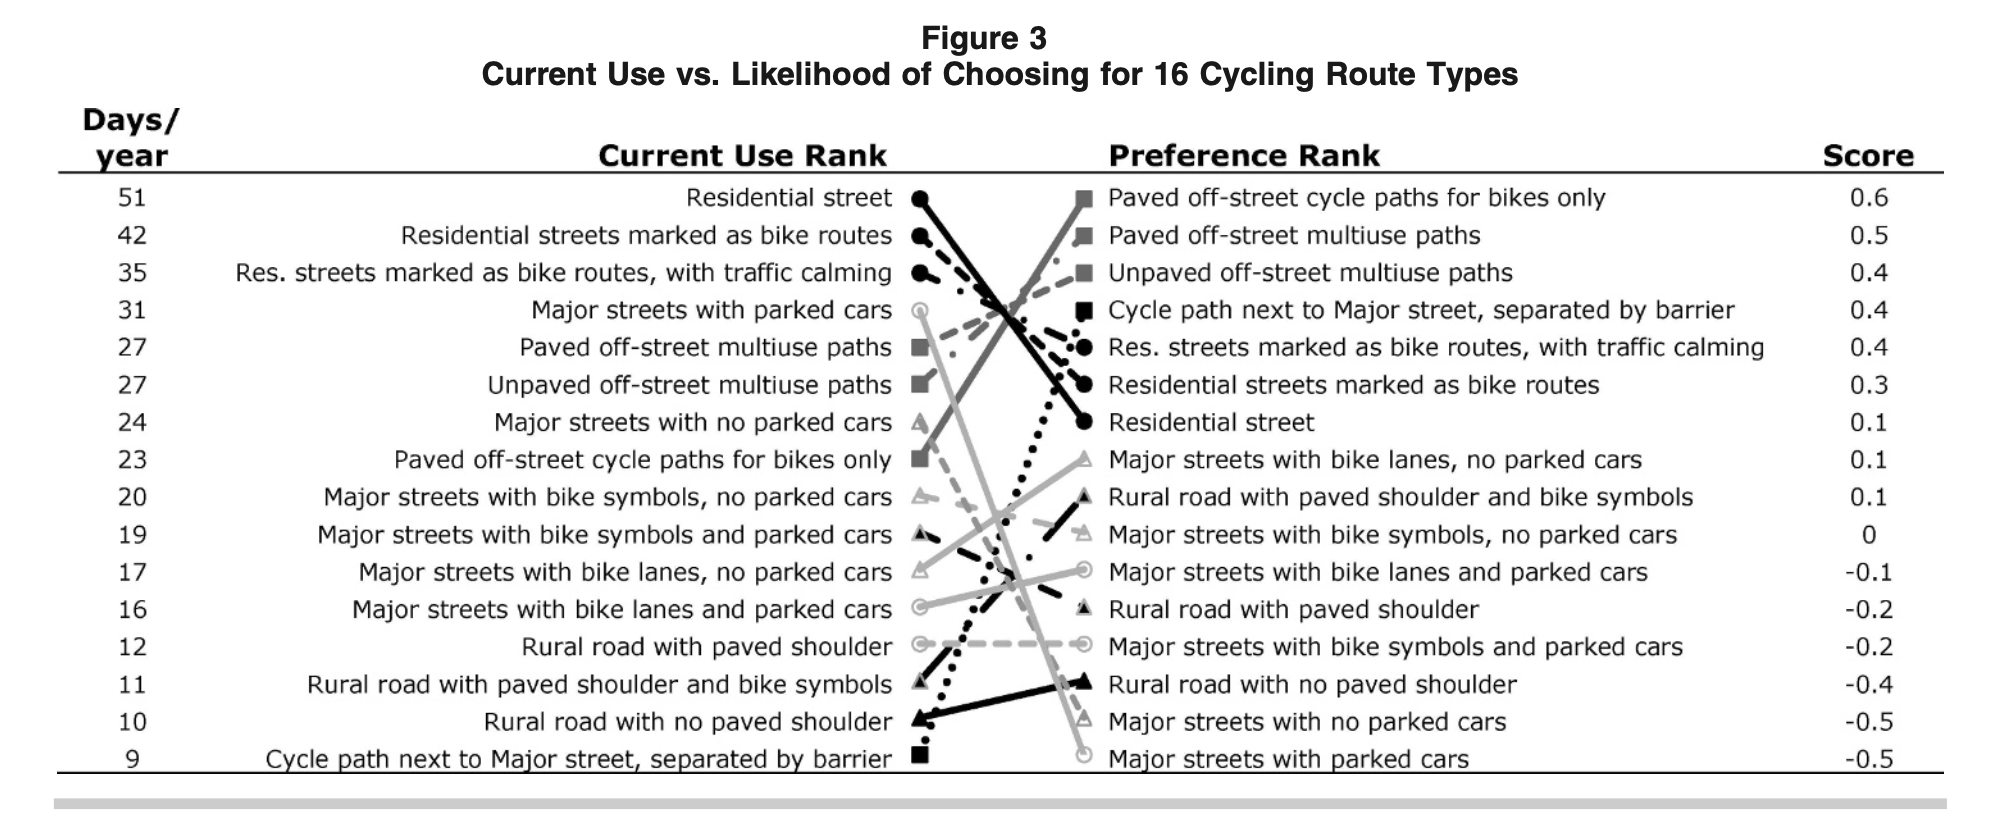

In [399]:
from IPython.display import Image
Image('route_preference.png')

We'll use a modified version of this table to factor our lengths in the column `length_fac`. For each type of road, we'll set the factor to:

$factor = (1 - score)$

We'll use a bunch of `np.where` statements to set the factor if it meets each conditional.

In [311]:
centreline_valid['length_fac'] = None

In [312]:
# multiuse paths
centreline_valid['length_fac'] = np.where(centreline_valid['INFRA_HIGHORDER'].isin(['Multi-Use Trail - Entrance',
                                                                                   'Multi-Use Trail','Park Road',
                                                                                   'Multi-Use Trail - Boulevard',
                                                                                   'MUT (2016 Network Plan/2012 Trails Plan)',
                                                                                    'Multi-Use Trail (Local)',
                                                                                    'MUT - Entrance (2016 Network Plan/2012 Trails Plan)']) 
                                          , 0.5, centreline_valid['length_fac'])

In [313]:
# catching errors in the where the Martin Goodman Trail bikeway does not exactly overlap with the centreline
centreline_valid['length_fac'] = np.where(centreline_valid['FCODE_DESC'].isin(['Trail']) 
                                          , 0.5, centreline_valid['length_fac']) 

In [314]:
# all separated bike paths or cycle tracks
centreline_valid['length_fac'] = np.where(centreline_valid['INFRA_HIGHORDER'].isin(['Contraflow Cycle Track',
                                                                                   'Cycle Track - Contraflow',
                                                                                   'Cycle Track']) 
                                          , 0.6, centreline_valid['length_fac'])

In [315]:
# residential roads
centreline_valid['length_fac'] = np.where(centreline_valid['INFRA_HIGHORDER'].isnull()
                                          & centreline_valid['FCODE_DESC'].isin(['Local', 'Collector', 'Walkway']),
                                          0.9, centreline_valid['length_fac'])

In [316]:
# residential roads signed as bike routes
centreline_valid['length_fac'] = np.where(centreline_valid['INFRA_HIGHORDER'].isin(['Signed Route (No Pavement Markings)',
                                                                                   'Sharrows - Wayfinding',
                                                                                   'Sharrows']) 
                                          & centreline_valid['FCODE_DESC'].isin(['Local', 'Collector']), 0.7, centreline_valid['length_fac'])

In [317]:
# residential bike lanes
centreline_valid['length_fac'] = np.where(centreline_valid['INFRA_HIGHORDER'].isin(['Bike Lane', 
                                                                                    'Bike Lane - Buffered', 
                                                                                    'Contraflow Bike Lane', 
                                                                                   'Bike Lane - Contraflow']) 
                                          & centreline_valid['FCODE_DESC'].isin(['Local', 'Collector']), 0.6, centreline_valid['length_fac'])

In [318]:
# arterials or major streets
centreline_valid['length_fac'] = np.where(centreline_valid['INFRA_HIGHORDER'].isnull()
                                          & centreline_valid['FCODE_DESC'].isin(['Major Arterial', 'Minor Arterial']),
                                          1.5, centreline_valid['length_fac'])

In [319]:
# bike lanes on arterials (but not cycle tracks/separated bike lanes)
centreline_valid['length_fac'] = np.where(centreline_valid['INFRA_HIGHORDER'].isin(['Bike Lane', 
                                                                                    'Bike Lane - Buffered', 
                                                                                    'Contraflow Bike Lane', 
                                                                                   'Bike Lane - Contraflow'])
                                          & centreline_valid['FCODE_DESC'].isin(['Major Arterial', 'Minor Arterial']),
                                          0.9, centreline_valid['length_fac'])

In [320]:
# arterials signed as bike routes
centreline_valid['length_fac'] = np.where(centreline_valid['INFRA_HIGHORDER'].isin(['Signed Route (No Pavement Markings)',
                                                                                   'Sharrows - Wayfinding',
                                                                                   'Sharrows', 'Sharrows - Arterial',
                                                                                   'Edge Line'])
                                          & centreline_valid['FCODE_DESC'].isin(['Major Arterial', 'Minor Arterial']),
                                          1.2, centreline_valid['length_fac'])

In [321]:
# lake shore trail was not properly matched in the lookup table, so we'll do some manual adjustments
centreline_valid['length_fac'] = np.where(centreline_valid['LF_NAME'] == 'Lake Shore Blvd East Trl',
                                          0.5, centreline_valid['length_fac'])

Our `length_adj` column will be the column that represents the `cost` to the cyclist as they take a path. We'll be using this column instead of `length` in `networkx`.

In [322]:
centreline_valid['length_adj'] = centreline_valid['length'] * centreline_valid['length_fac'] 

### Preparing the Nodes

In [323]:
intersections.head()

INT_ID  ELEV_ID                                  INTERSEC5 CLASSIFI6  \
0  13469938    20548             GARDINER EXPRESS / Kipling Ave     SEUML   
1  13469938    29774             GARDINER EXPRESS / Kipling Ave     SEUML   
2  13469952     9472  Kipling Ave / Kipling S Gardiner C E Ramp     MNRML   
3  13469952    28079  Kipling Ave / Kipling S Gardiner C E Ramp     MNRML   
4  13469946    32748             GARDINER EXPRESS / Kipling Ave     SEUML   

                                CLASSIFI7  NUM_ELEV  ELEVATIO9 ELEVATIO10  \
0  Pseudo Intersection-Overpass/Underpass         2     509200     Pseudo   
1  Pseudo Intersection-Overpass/Underpass         2     509200     Pseudo   
2                       Minor-Multi Level         2     501300      Minor   
3                       Minor-Multi Level         2     509200     Pseudo   
4  Pseudo Intersection-Overpass/Underpass         2     509200     Pseudo   

   ELEV_LEVEL  ELEVATION ELEVATIO13  HEIGHT_R14 HEIGHT_R15           X  \
0           0        0.0       None         0.0       None  302703.415   
1           1        0.0       None         0.0       None  302703.415   
2           1        0.0       None         0.0       None  302713.398   
3           0        0.0       None         0.0       None  302713.398   
4           0        0.0       None         0.0       None  302711.225   

             Y  LONGITUDE   LATITUDE  OBJECTID                    geometry  
0  4830674.977 -79.525779  43.618007      41.0  POINT (-79.52578 43.61801)  
1  4830674.977 -79.525779  43.618007      42.0  POINT (-79.52578 43.61801)  
2  4830626.325 -79.525656  43.617569      39.0  POINT (-79.52566 43.61757)  
3  4830626.325 -79.525656  43.617569      40.0  POINT (-79.52566 43.61757)  
4  4830637.839 -79.525683  43.617673      45.0  POINT (-79.52568 43.61767)

We'll be using these columns from the intersections file:
* `INT_ID` and `INTERSEC5` - to identify the intersection and to link it to the centreline
* `CLASSIFI6` and `CLASSIFI7` - the classification of intersection
* `geometry`

In [324]:
intersections = intersections[['INT_ID', 'INTERSEC5', 'CLASSIFI6', 'CLASSIFI7', 'geometry']]

In [325]:
intersections = intersections.to_crs(epsg = '26917')
for index, row in intersections.iterrows():
    rotated = shapely.affinity.rotate(row['geometry'], angle=-17, origin = Point(0, 0))
    intersections.at[index, 'geometry'] = rotated

While we aren't using these classifications, its interesting to note that like the centreline, the intersections file includes more than just road intersections. Pseudo intersections are ones where a road on an overpass/tunnel crosses another road, while Statistical intersections are when roads cross a jurisdictional boundary.

In [326]:
intersections['CLASSIFI7'].unique()

array(['Pseudo Intersection-Overpass/Underpass', 'Minor-Multi Level',
       'Lesser-Single Level', 'Minor-Single Level',
       'Expressway Interchange-Single Level', 'Cul de Sac-Single Level',
       'Pseudo Intersection-Single Level', 'Statistical-Single Level',
       'Lesser-Multi Level', 'Major-Single Level', 'Major-Multi Level',
       'Error No Domain Descrption'], dtype=object)

`networkx` requires us to feed them a discrete x and y coordinate, so we'll construct this column now.

In [327]:
intersections['X'] = intersections.geometry.x
intersections['Y'] = intersections.geometry.y
intersections

INT_ID                                    INTERSEC5 CLASSIFI6  \
0      13469938               GARDINER EXPRESS / Kipling Ave     SEUML   
1      13469938               GARDINER EXPRESS / Kipling Ave     SEUML   
2      13469952    Kipling Ave / Kipling S Gardiner C E Ramp     MNRML   
3      13469952    Kipling Ave / Kipling S Gardiner C E Ramp     MNRML   
4      13469946               GARDINER EXPRESS / Kipling Ave     SEUML   
...         ...                                          ...       ...   
53730  13455527                    Divadale Dr / Don Avon Dr     MNRSL   
53731  13455391                   Broadway Ave / Don Avon Dr     MNRSL   
53732  13455352  Brentcliffe Rd / Broadway Ave / Rykert Cres     MNRSL   
53733  13455357                               Brentcliffe Rd     MNRSL   
53734  13455308                Brentcliffe Rd / Broadway Ave     MNRSL   

                                    CLASSIFI7  \
0      Pseudo Intersection-Overpass/Underpass   
1      Pseudo Intersection-Overpass/Underpass   
2                           Minor-Multi Level   
3                           Minor-Multi Level   
4      Pseudo Intersection-Overpass/Underpass   
...                                       ...   
53730                      Minor-Single Level   
53731                      Minor-Single Level   
53732                      Minor-Single Level   
53733                      Minor-Single Level   
53734                      Minor-Single Level   

                              geometry             X             Y  
0      POINT (2004207.843 4438469.314)  2.004208e+06  4.438469e+06  
1      POINT (2004207.843 4438469.314)  2.004208e+06  4.438469e+06  
2      POINT (2004204.058 4438419.800)  2.004204e+06  4.438420e+06  
3      POINT (2004204.058 4438419.800)  2.004204e+06  4.438420e+06  
4      POINT (2004205.136 4438431.466)  2.004205e+06  4.438431e+06  
...                                ...           ...           ...  
53730  POINT (2019810.850 4445320.060)  2.019811e+06  4.445320e+06  
53731  POINT (2019809.598 4445420.784)  2.019810e+06  4.445421e+06  
53732  POINT (2019896.562 4445424.509)  2.019897e+06  4.445425e+06  
53733  POINT (2019982.356 4445395.287)  2.019982e+06  4.445395e+06  
53734  POINT (2019992.486 4445424.112)  2.019992e+06  4.445424e+06  

[53735 rows x 7 columns]

In [328]:
nodes = intersections[['INT_ID', 'X', 'Y']]

### Feeding into `networkx`

We'll do a double inner join on the `FNODE` and `TNODE` to make sure that any link we send in has an associated intersection in the intersections file.

In [329]:
edges = centreline_valid.merge(nodes, left_on = 'FNODE', right_on = 'INT_ID', how = 'inner')[['FNODE', 'TNODE', 'GEO_ID', 'length_adj']]
edges = edges.merge(nodes, left_on = 'TNODE', right_on = 'INT_ID', how = 'inner')[['FNODE', 'TNODE', 'GEO_ID', 'length_adj']]
edges

FNODE     TNODE    GEO_ID  length_adj
0      13470579  13470553    914632   86.874711
1      13470540  13470553   7632579  131.404261
2      13470579  13470587    914644  164.727813
3      14301439  13470587  14301438   43.114767
4      30105416  13470587  30105484   34.139422
...         ...       ...       ...         ...
64162  13447087  13446984   6541762  122.229607
64163  20051187  13443677  20051186    39.50055
64164  20051187  13443677  20051186    39.50055
64165  13441591  30064465  30064466  104.908461
64166  13449808  13449874    440829  204.779724

[64167 rows x 4 columns]

In [330]:
edges = edges.drop_duplicates()

Similarly, since we already filtered out a lot of features such as railways and rivers, we'll do another set of inner joins to make sure we only include nodes connecting to a link.

In [331]:
nodes = nodes.merge(edges, left_on = 'INT_ID', right_on = 'FNODE', how = 'inner')[['INT_ID', 'X', 'Y']]
nodes = nodes.merge(edges, left_on = 'INT_ID', right_on = 'TNODE', how = 'inner')[['INT_ID', 'X', 'Y']]
nodes

INT_ID             X             Y
0      13469938  2.004208e+06  4.438469e+06
1      13469938  2.004208e+06  4.438469e+06
2      13469952  2.004204e+06  4.438420e+06
3      13469952  2.004204e+06  4.438420e+06
4      13469946  2.004205e+06  4.438431e+06
...         ...           ...           ...
74896  13455352  2.019897e+06  4.445425e+06
74897  13455357  2.019982e+06  4.445395e+06
74898  13455357  2.019982e+06  4.445395e+06
74899  13455308  2.019992e+06  4.445424e+06
74900  13455308  2.019992e+06  4.445424e+06

[74901 rows x 3 columns]

In [332]:
nodes = nodes.drop_duplicates()
nodes

INT_ID             X             Y
0      13469938  2.004208e+06  4.438469e+06
2      13469952  2.004204e+06  4.438420e+06
4      13469946  2.004205e+06  4.438431e+06
6      13469942  2.004206e+06  4.438449e+06
8      13469930  2.004210e+06  4.438489e+06
...         ...           ...           ...
74883  13455527  2.019811e+06  4.445320e+06
74887  13455391  2.019810e+06  4.445421e+06
74891  13455352  2.019897e+06  4.445425e+06
74897  13455357  2.019982e+06  4.445395e+06
74899  13455308  2.019992e+06  4.445424e+06

[33741 rows x 3 columns]

In [333]:
edges

FNODE     TNODE    GEO_ID  length_adj
0      13470579  13470553    914632   86.874711
1      13470540  13470553   7632579  131.404261
2      13470579  13470587    914644  164.727813
3      14301439  13470587  14301438   43.114767
4      30105416  13470587  30105484   34.139422
...         ...       ...       ...         ...
64159  30021444  13444548  30021446   41.239712
64161  13447087  13446984   6541762  122.229607
64163  20051187  13443677  20051186    39.50055
64165  13441591  30064465  30064466  104.908461
64166  13449808  13449874    440829  204.779724

[52176 rows x 4 columns]

First we'll create the network, or the graph.

In [335]:
g = nx.Graph()

Then we'll feed in the links. The first 2 arguments are the start and end nodes, the third is the `length_adj` column, and the last argument is the unique identifier for the link, or the `GEO_ID` that ties back to the centreline file.

In [336]:
for index, row in edges.iterrows():
    g.add_edge(row[0], row[1], length = row[3], key = row[2])

For the nodes, the first argument is the unique identifier, while the second is the X and Y coordinates. We won't be using `networkx` to draw our network flows since eats too much memory, so the position argument is not as important.

In [337]:
for i, row in nodes.iterrows():
    g.add_node(row[0], pos = (row[1], row[2]))

## Preparing the Trips

In [338]:
trips = pd.read_csv('trips_raw_data.csv')

/Users/Rick/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [339]:
trips['Start Time'] = pd.DatetimeIndex(trips['Start Time'])

We'll only be analyzing 2019, since it represents a normal year.

In [340]:
trips = trips[trips['Start Time'].dt.year == 2019]

In [341]:
trips

Unnamed: 0  Trip Id  Subscription Id  Trip Duration  \
3232109     3232167  4581278         199751.0           1547   
3232110     3232168  4581279         294730.0           1112   
3232111     3232169  4581280         197252.0            589   
3232112     3232170  4581281         171700.0            259   
3232113     3232171  4581282         306314.0            281   
...             ...      ...              ...            ...   
5570570     5570628  7334123         474257.0            523   
5570571     5570629  7334124         330999.0            273   
5570572     5570630  7334125         521717.0           1055   
5570573     5570631  7334126         312708.0            459   
5570574     5570632  7334127         361530.0            361   

         Start Station Id                Start Time  \
3232109            7021.0 2019-01-01 00:08:00-05:00   
3232110            7160.0 2019-01-01 00:10:00-05:00   
3232111            7055.0 2019-01-01 00:15:00-05:00   
3232112            7012.0 2019-01-01 00:16:00-05:00   
3232113            7041.0 2019-01-01 00:19:00-05:00   
...                   ...                       ...   
5570570            7098.0 2019-12-31 23:39:00-05:00   
5570571            7044.0 2019-12-31 23:45:00-05:00   
5570572            7100.0 2019-12-31 23:51:00-05:00   
5570573            7470.0 2019-12-31 23:55:00-05:00   
5570574            7168.0 2019-12-31 23:58:00-05:00   

                              Start Station Name  End Station Id  \
3232109                       Bay St / Albert St          7233.0   
3232110                 King St W / Tecumseth St          7051.0   
3232111                   Jarvis St / Carlton St          7013.0   
3232112  Elizabeth St / Edward St (Bus Terminal)          7235.0   
3232113                     Edward St / Yonge St          7257.0   
...                                          ...             ...   
5570570     Riverdale Park South (Broadview Ave)          7339.0   
5570571                 Church St / Alexander St          7273.0   
5570572           Dundas St E / Regent Park Blvd          7100.0   
5570573              York St / Lake Shore Blvd W          7102.0   
5570574                   Queens Quay / Yonge St          7033.0   

                          End Time                         End Station Name  \
3232109  2019-01-01 00:33:00-05:00                 King / Cowan Ave - SMART   
3232110  2019-01-01 00:29:00-05:00                    Mutual St / Shuter St   
3232111  2019-01-01 00:25:00-05:00                 Scott St / The Esplanade   
3232112  2019-01-01 00:20:00-05:00  Bay St / College St (West Side) - SMART   
3232113  2019-01-01 00:24:00-05:00             Dundas St W / St. Patrick St   
...                            ...                                      ...   
5570570  2019-12-31 23:48:00-05:00              Carlaw Ave / Strathcona Ave   
5570571  2019-12-31 23:49:00-05:00              Bay St / Charles St - SMART   
5570572  2020-01-01 00:08:00-05:00           Dundas St E / Regent Park Blvd   
5570573  2020-01-01 00:03:00-05:00                    Nelson St / Duncan St   
5570574  2020-01-01 00:04:00-05:00                            Union Station   

         ...  Temp (°C) Dew Point Temp (°C) Rel Hum (%) Wind Dir (10s deg)  \
3232109  ...        4.3                 4.0        98.0                8.0   
3232110  ...        4.3                 4.0        98.0                8.0   
3232111  ...        4.3                 4.0        98.0                8.0   
3232112  ...        4.3                 4.0        98.0                8.0   
3232113  ...        4.3                 4.0        98.0                8.0   
...      ...        ...                 ...         ...                ...   
5570570  ...        0.2                -3.7        75.0               25.0   
5570571  ...        0.2                -3.7        75.0               25.0   
5570572  ...        0.2                -3.7        75.0               25.0   
5570573  ...        0.2          

Since our graph is based on nodes and links, we need to map each bikeshare station to an intersection. Lets load in the bikeshare stations layer as a GeoDataFrame.

In [342]:
stations = pd.read_csv('bikeshare_stations.csv')
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.lon, stations.lat))
stations_gdf.set_crs(epsg = '4326', inplace=True)
stations_gdf = stations_gdf.to_crs(epsg = '26917')
for index, row in stations_gdf.iterrows():
    rotated = shapely.affinity.rotate(row['geometry'], angle=-17, origin = Point(0, 0))
    stations_gdf.at[index, 'geometry'] = rotated

We'll only be mapping the stations to nodes that are in our network, so we'll filter out nodes that aren't connected to any valid links.

In [343]:
intersections_valid = intersections[intersections['INT_ID'].isin(list(centreline_valid['FNODE'].unique()))]

Making the X and Y coordinates discrete columns.

In [344]:
stations_gdf['x'] = stations_gdf.geometry.x
stations_gdf['y'] = stations_gdf.geometry.y

In [345]:
stations_gdf

Station Id                       Station Name        lat        lon  \
0          7000       Fort York  Blvd / Capreol Ct  43.639832 -79.395954   
1          7001    Lower Jarvis St / The Esplanade  43.647830 -79.370698   
2          7002         St. George St / Bloor St W  43.667333 -79.399429   
3          7003           Madison Ave / Bloor St W  43.667158 -79.402761   
4          7004            University Ave / Elm St  43.656518 -79.389099   
..          ...                                ...        ...        ...   
605        7663             Kilgour Rd / Rumsey Rd  43.718039 -79.371914   
606        7664  Sunnybrook Health Center - L Wing  43.722680 -79.376440   
607        7665  Sunnybrook Health Centre - S Wing  43.720669 -79.377553   
608        7666         Dundas St W / St Helen Ave  43.650422 -79.440765   
609        7667           Spadina Ave / Sussex Ave  43.664733 -79.403028   

     capacity                         geometry             x             y  
0          35  POINT (2014946.157 4437923.978)  2.014946e+06  4.437924e+06  
1          15  POINT (2017148.903 4438220.892)  2.017149e+06  4.438221e+06  
2          19  POINT (2015513.197 4440938.865)  2.015513e+06  4.440939e+06  
3          15  POINT (2015249.463 4440993.758)  2.015249e+06  4.440994e+06  
4          11  POINT (2015985.467 4439555.301)  2.015985e+06  4.439555e+06  
..        ...                              ...           ...           ...  
605        17  POINT (2019187.990 4445749.433)  2.019188e+06  4.445749e+06  
606        15  POINT (2018978.287 4446345.068)  2.018978e+06  4.446345e+06  
607        11  POINT (2018830.957 4446154.767)  2.018831e+06  4.446155e+06  
608        26  POINT (2011792.301 4440046.061)  2.011792e+06  4.440046e+06  
609        19  POINT (2015154.969 4440740.603)  2.015155e+06  4.440741e+06  

[610 rows x 8 columns]

The first step to mapping the stations to an intersection is to create a cross join. This means each row will be joined to all other rows in both datasets. To do this, we'll create a zero column in both datasets, and join on that column of zeroes.

In [346]:
intersections_valid['key'] = 0
stations_gdf['key'] = 0

cross_join = intersections_valid.merge(stations_gdf[['key', 'Station Id', 'x', 'y']], how='outer')

/Users/Rick/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [347]:
cross_join

INT_ID                       INTERSEC5 CLASSIFI6  \
0         13469938  GARDINER EXPRESS / Kipling Ave     SEUML   
1         13469938  GARDINER EXPRESS / Kipling Ave     SEUML   
2         13469938  GARDINER EXPRESS / Kipling Ave     SEUML   
3         13469938  GARDINER EXPRESS / Kipling Ave     SEUML   
4         13469938  GARDINER EXPRESS / Kipling Ave     SEUML   
...            ...                             ...       ...   
24154775  13455308   Brentcliffe Rd / Broadway Ave     MNRSL   
24154776  13455308   Brentcliffe Rd / Broadway Ave     MNRSL   
24154777  13455308   Brentcliffe Rd / Broadway Ave     MNRSL   
24154778  13455308   Brentcliffe Rd / Broadway Ave     MNRSL   
24154779  13455308   Brentcliffe Rd / Broadway Ave     MNRSL   

                                       CLASSIFI7  \
0         Pseudo Intersection-Overpass/Underpass   
1         Pseudo Intersection-Overpass/Underpass   
2         Pseudo Intersection-Overpass/Underpass   
3         Pseudo Intersection-Overpass/Underpass   
4         Pseudo Intersection-Overpass/Underpass   
...                                          ...   
24154775                      Minor-Single Level   
24154776                      Minor-Single Level   
24154777                      Minor-Single Level   
24154778                      Minor-Single Level   
24154779                      Minor-Single Level   

                                 geometry             X             Y  key  \
0         POINT (2004207.843 4438469.314)  2.004208e+06  4.438469e+06    0   
1         POINT (2004207.843 4438469.314)  2.004208e+06  4.438469e+06    0   
2         POINT (2004207.843 4438469.314)  2.004208e+06  4.438469e+06    0   
3         POINT (2004207.843 4438469.314)  2.004208e+06  4.438469e+06    0   
4         POINT (2004207.843 4438469.314)  2.004208e+06  4.438469e+06    0   
...                                   ...           ...           ...  ...   
24154775  POINT (2019992.486 4445424.112)  2.019992e+06  4.445424e+06    0   
24154776  POINT (2019992.486 4445424.112)  2.019992e+06  4.445424e+06    0   
24154777  POINT (2019992.486 4445424.112)  2.019992e+06  4.445424e+06    0   
24154778  POINT (2019992.486 4445424.112)  2.019992e+06  4.445424e+06    0   
24154779  POINT (2019992.486 4445424.112)  2.019992e+06  4.445424e+06    0   

          Station Id             x             y  
0               7000  2.014946e+06  4.437924e+06  
1               7001  2.017149e+06  4.438221e+06  
2               7002  2.015513e+06  4.440939e+06  
3               7003  2.015249e+06  4.440994e+06  
4               7004  2.015985e+06  4.439555e+06  
...              ...           ...           ...  
24154775        7663  2.019188e+06  4.445749e+06  
24154776        7664  2.018978e+06  4.446345e+06  
24154777        7665  2.018831e+06  4.446155e+06  
24154778        7666  2.011792e+06  4.440046e+06  
24154779        7667  2.015155e+06  4.440741e+06  

[24154780 rows x 11 columns]

After cross joining the two datasets, we'll calculate the euclidean distance between the stations and the intersections. Since this a cross join, this is being done for every possible combination of station-intersection.

Because we're in a mercator projection, and working on a relatively small area, we can make the assumption that our surface is planar, and use pythagoreas theorem to calculate the distance. This will significantly speed up the calculation rather than relying on a function to process 24 million rows.

In [348]:
cross_join['dist'] = (cross_join['X'] - cross_join['x'])**2 + (cross_join['Y'] - cross_join['y'])**2

To complete the mapping, we'll group by the station ID, and take the lowest distance, before rejoining the data back to the intersections dataset to grab the `INT_ID`.

In [349]:
intersections_lookup = cross_join.groupby('Station Id').agg({'dist':'min'}).merge(cross_join, left_on = ['dist'], right_on = ['dist'], how = 'inner')

In [350]:
intersections_lookup = intersections_lookup.sort_values(by='dist').drop_duplicates('Station Id', keep = 'first').reset_index()[['INT_ID', 'Station Id']]

Now we can do some joins to map each `Station Id` in the trips dataset to an `INT_ID`.

In [351]:
trips = trips[['Start Station Id', 'End Station Id']]
trips = trips.merge(intersections_lookup, left_on = 'Start Station Id', right_on = 'Station Id')

In [352]:
trips = trips.rename(columns = {'INT_ID': 'START INT'})
trips = trips[['Start Station Id', 'End Station Id', 'START INT']]

In [353]:
trips

Start Station Id  End Station Id  START INT
0                  7021.0          7233.0   13466250
1                  7021.0          7253.0   13466250
2                  7021.0          7323.0   13466250
3                  7021.0          7052.0   13466250
4                  7021.0          7036.0   13466250
...                   ...             ...        ...
2338461            7510.0          7226.0   30016301
2338462            7510.0          7411.0   30016301
2338463            7510.0          7043.0   30016301
2338464            7510.0          7411.0   30016301
2338465            7510.0          7243.0   30016301

[2338466 rows x 3 columns]

In [354]:
trips = trips.merge(intersections_lookup, left_on = 'End Station Id', right_on = 'Station Id')
trips = trips.rename(columns = {'INT_ID': 'END INT'})
trips = trips[['START INT', 'END INT']]

To avoid running `networkx` through 2 million trips, we'll only run `networkx` through unique origin destination pairs, then multiply the resulting path by the number of trips made for that origin destination pair. We can do that by grouping by both the `START INT` and `END INT`.

This brings us down to 112,705 replications that we need to run `networkx` for.

In [355]:
trip_od = trips.groupby(['START INT', 'END INT']).size().reset_index().rename(columns = {0: 'trips'})

In [356]:
trip_od

START INT   END INT  trips
0        13455496  13455496     14
1        13455496  13455992      6
2        13455496  13456388     19
3        13455496  13456611      9
4        13455496  13456893     25
...           ...       ...    ...
112700   30111086  30104384      2
112701   30111086  30105329      1
112702   30111086  30107059     55
112703   30111086  30109166      3
112704   30111086  30111086     23

[112705 rows x 3 columns]

In [357]:
trip_od.sort_values(by = 'trips', ascending = False)

START INT   END INT  trips
73790    13467729  13467389   2043
110044   30102397  13468181   2001
98995    30021888  30021888   1787
79548    13468181  30102397   1678
50169    13466203  13466203   1555
...           ...       ...    ...
31904    13464870  30098085      1
96370    30012003  13463195      1
68242    13467348  30008207      1
96367    30012003  13462831      1
75212    13467820  13464522      1

[112705 rows x 3 columns]

## Running `networkx` to find the path for each OD pair

Some assumptions this process is making:
* Topography doesn't matter. We didn't factor the length based on grade/elevation changes, so a cyclist will assume a flat route and a hilly route of the same cost is the same
* There are no constraints other than minimizing the cost. Its definitely possible some riders may complete a tour of the city, avoid using the shortest path, but this analysis won't take that into account. Similarly, if a rider makes a mid route detour, this won't be captured.
* Bikeshare users might be more conservative than regular cyclists in choosing their paths. Unfortunately, we couldn't afford to spend more time on researching this behaviour.

In [358]:
trip_od['trips'].sum()

2338466

Additionally, a small number of trips (capturing the "touring" behaviour) start and end at the same station. This, and similar trips will not be properly captured in `networkx` since it will just return an empty path.

In [359]:
trip_od[trip_od['START INT'] == trip_od['END INT']]['trips'].sum()

50203

As an example, lets route the most popular origin-destination pair, from 30102397 to 13468181. This pair has 2043 trips, and is from Queens' Quay and Bathurst, to Queens Quay and York.

The first step is to use the shortest path function. This uses the dijkstra shortest path algorithm to calculate the shortest path, based on our cost column `length_adj`. 

Then, we can create another graph from that path that only contains the nodes and links that were used to construct that path. This is how we can extract the links from the graph.

In [360]:
route = []
most_popular_graph = nx.shortest_path(g, 30102397, 13468181, weight='length') # dijkstra

most_popular_route = nx.path_graph(most_popular_graph)  

for ea in most_popular_route.edges():
    route.append(g.edges[ea[0], ea[1]]['key'])

In [361]:
centreline_unrotate = gpd.read_file('centreline.geojson')

Now we can grab the associated geometries from the centreline file to map it. The basemap function `contextily` requires us to use web mercator, so we'll need to use `epsg = 3857`.

In [362]:
route_poly = centreline_unrotate[centreline_unrotate['GEO_ID'].isin(route)].to_crs(epsg = '3857')
boundary = gpd.read_file('to_boundary.geojson')

In [363]:
plt.rcParams['figure.dpi'] = 450

In [364]:
import contextily as cx
to_basemap = cx.Place("Toronto, Canada")


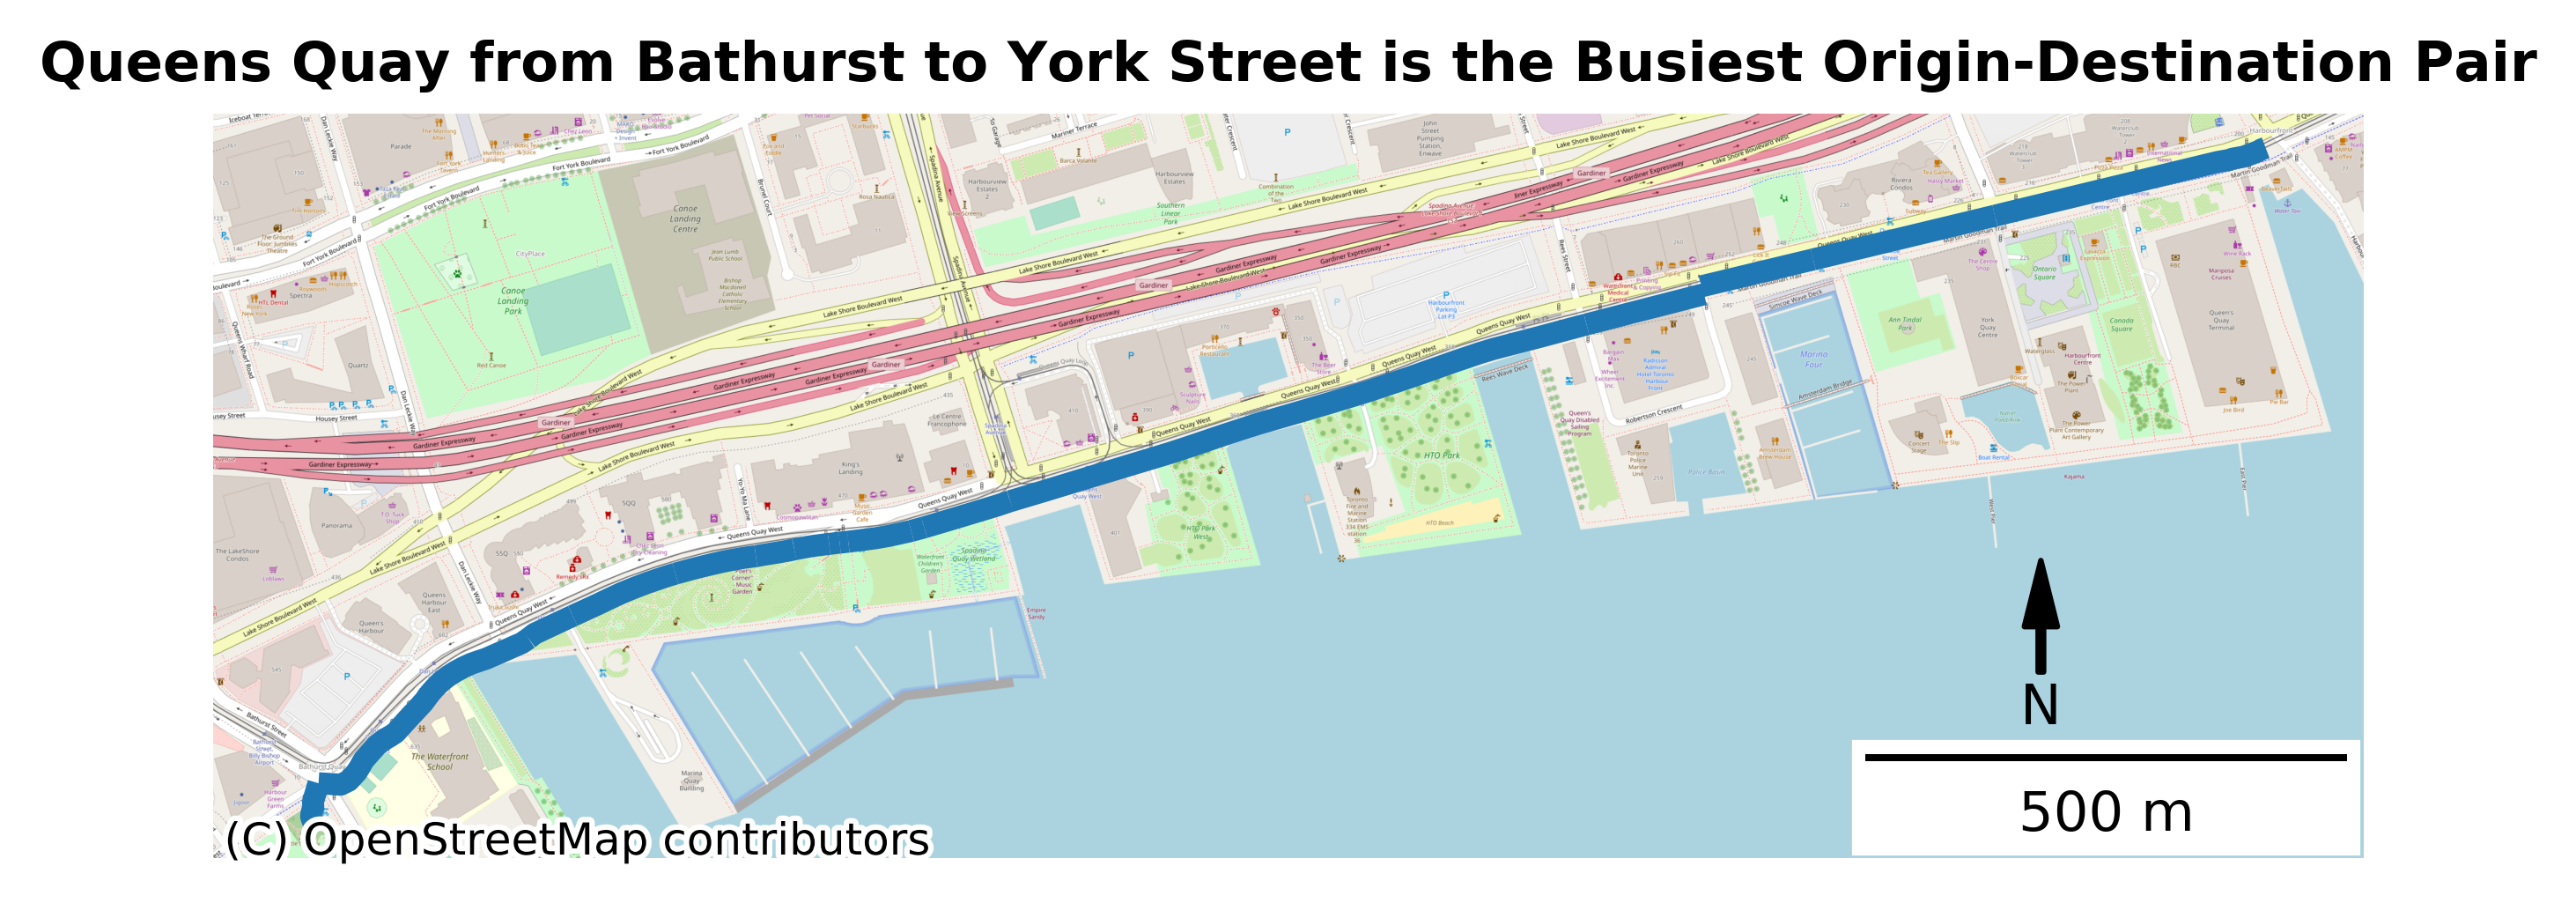

In [365]:
fig, ax = plt.subplots()

ax.set_title('Queens Quay from Bathurst to York Street is the Busiest Origin-Destination Pair', fontsize = 10, fontweight = 'bold')

fig.set_size_inches(7,4)

route_poly.plot(ax = ax, linewidth = 4)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

#north arrow
x, y, arrow_length = 0.85, 0.4, 0.15
ax.annotate('N', xy=(x, y), xytext=(x, y- 0.20),
            arrowprops = dict(facecolor='black', width=1, headwidth=6),
            ha='center', va='center', fontsize=10,
            xycoords=ax.transAxes)


ax.add_artist(ScaleBar(1, location = 'lower right', length_fraction = 0.25))# scale bar



In [366]:
trip_od = trip_od[trip_od['START INT'] != trip_od['END INT']]
trip_od

START INT   END INT  trips
1        13455496  13455992      6
2        13455496  13456388     19
3        13455496  13456611      9
4        13455496  13456893     25
5        13455496  13457177      3
...           ...       ...    ...
112699   30111086  30100054     12
112700   30111086  30104384      2
112701   30111086  30105329      1
112702   30111086  30107059     55
112703   30111086  30109166      3

[112256 rows x 3 columns]

Now that we know the process for a single origin-destination pair, we can operationalize this in a loop. For each loop, once we extract the links, we'll assign it to a list that will save the number of trips, and the links used in that trip.

We're using a `try/except` statement because certain pairs could not be routed and broke the loop. This ensures that even if a trip could not be routed, we can still continue the loop.

In [367]:
start = time.time()
route_table = []
unroutable = []
next_start = time.time()

for index, row in trip_od.iterrows():

    try:
        sp = nx.shortest_path(g, row['START INT'], row['END INT'], weight='length') # dijkstra algorithm

        pathGraph = nx.path_graph(sp) # assigning subgraph

        for ea in pathGraph.edges(): # appending edges in shortest path to list
            route_table.append([g.edges[ea[0], ea[1]]['key'], row['trips']])
    except:
        unroutable.append([row['START INT'], row['END INT'], row['trips']])
        
    if index%5000 == 0:
        print(index, time.time() - next_start)
        next_start = time.time()
        
print(time.time() - start)

5000 128.49723386764526
10000 94.51697301864624
15000 84.65551280975342
20000 86.0250608921051
25000 74.0934100151062
30000 70.85792303085327
35000 80.82517695426941
40000 62.64110016822815
45000 67.14286303520203
50000 56.84524703025818
55000 808.9101841449738
60000 72.0498399734497
65000 49.30156493186951
70000 40.46546983718872
75000 35.25971508026123
80000 38.99359583854675
85000 56.84396004676819
90000 75.8730080127716
100000 121.75331473350525
105000 75.83816814422607
110000 68.28335690498352
2283.8705089092255


After running for 30 minutes, we successfully routed almost every pair. However, 12.7% of all trips could not find a path. 

For this project, we didn't spend any time investigating the unroutable trips, but from the results, it seemed like only Old Toronto trips were successfully routed.

In [368]:
unroutable_df = pd.DataFrame.from_records(unroutable, columns = ['START INT', 'END INT', 'trips'])
round(unroutable_df['trips'].sum()/trip_od['trips'].sum()*100,3)

12.692

In [369]:
pd.DataFrame.from_records(route_table).to_csv('routes.csv') # saving the file

In [370]:
centreline_counts = pd.DataFrame.from_records(route_table)

In [371]:
centreline_counts.columns = ['GEO_ID', 'volume']

To condense the table, we'll group by each `GEO_ID`, and then sum up all the `trips` occuring on that segment to get a column we'll name `volume`. Then we'll merge it back onto the centreline layer to grab other data we need.

In [372]:
centreline_counts = centreline_counts.groupby('GEO_ID').sum().sort_values(by = 'volume', ascending = False).reset_index()

In [373]:
centreline_counts = centreline.merge(centreline_counts, how = 'inner')

For a later chart, lets find the top 500 road segments for bikeshare users.

In [374]:
top_500 = centreline_counts.sort_values(by = 'volume', ascending = True).tail(500)

In [375]:
to_boundary = gpd.read_file('toronto.geojson')
to_boundary = to_boundary.to_crs(epsg = '26917')
for index, row in to_boundary.iterrows():
    rotated = shapely.affinity.rotate(row['geometry'], angle=-17, origin = Point(0, 0))
    to_boundary.at[index, 'geometry'] = rotated

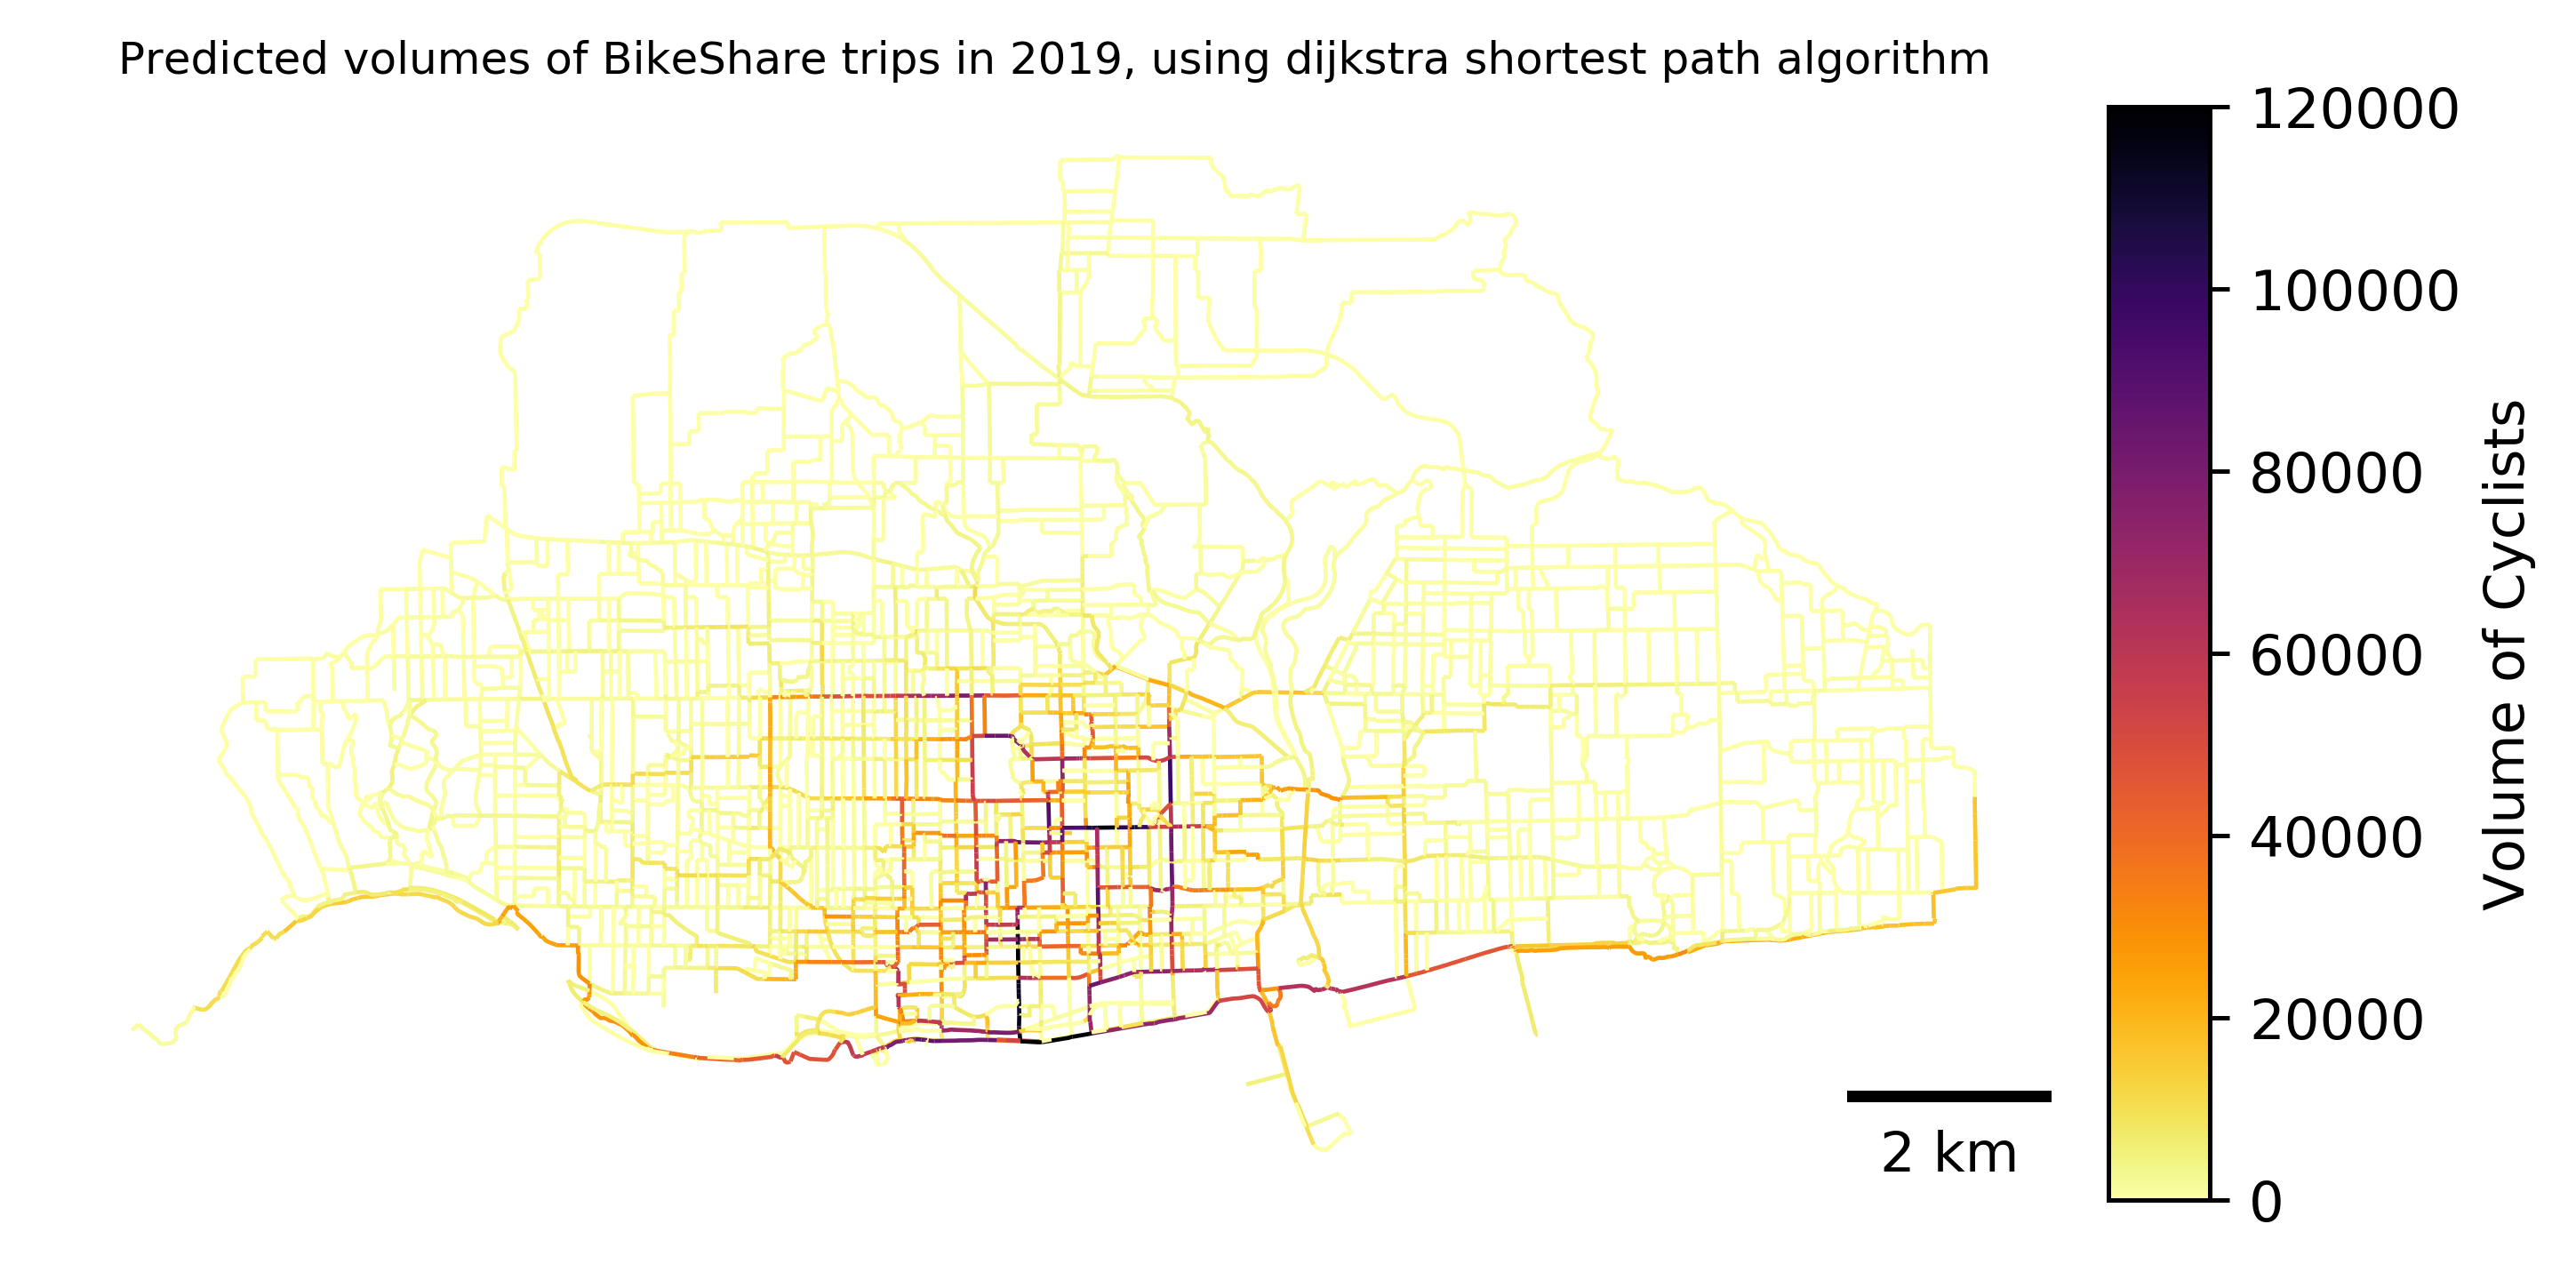

In [376]:
fig, ax = plt.subplots()
fig.set_size_inches(7,4)

divider = make_axes_locatable(ax) 

cax = divider.append_axes("right", size="5%", pad=0.1) #to clean up the chloropleth legend

centreline_counts.plot(ax = ax, column = 'volume', cmap = 'inferno_r', legend = True, linewidth = 0.75, zorder = 2,
                     legend_kwds={'label': "Volume of Cyclists"}, cax = cax, vmin = -0, vmax = 120000)


ax.set_title('Predicted volumes of BikeShare trips in 2019, using dijkstra shortest path algorithm', fontsize = 8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_axis_off()

ax.add_artist(ScaleBar(1, location = 'lower right', length_fraction = 0.25))# scale bar


This inital chloropleth plot of the busyness of each segment is a little overplotted. Almost every road in Old Toronto has a trip, and its very likely that these roads only receive only a few trips for all of 2019.

In [377]:
ylim = ax.get_ylim() #saving the extents for a later map
xlim = ax.get_xlim()

Lets create a simple histogram to understand the distribution of our data.

(0, 1000)

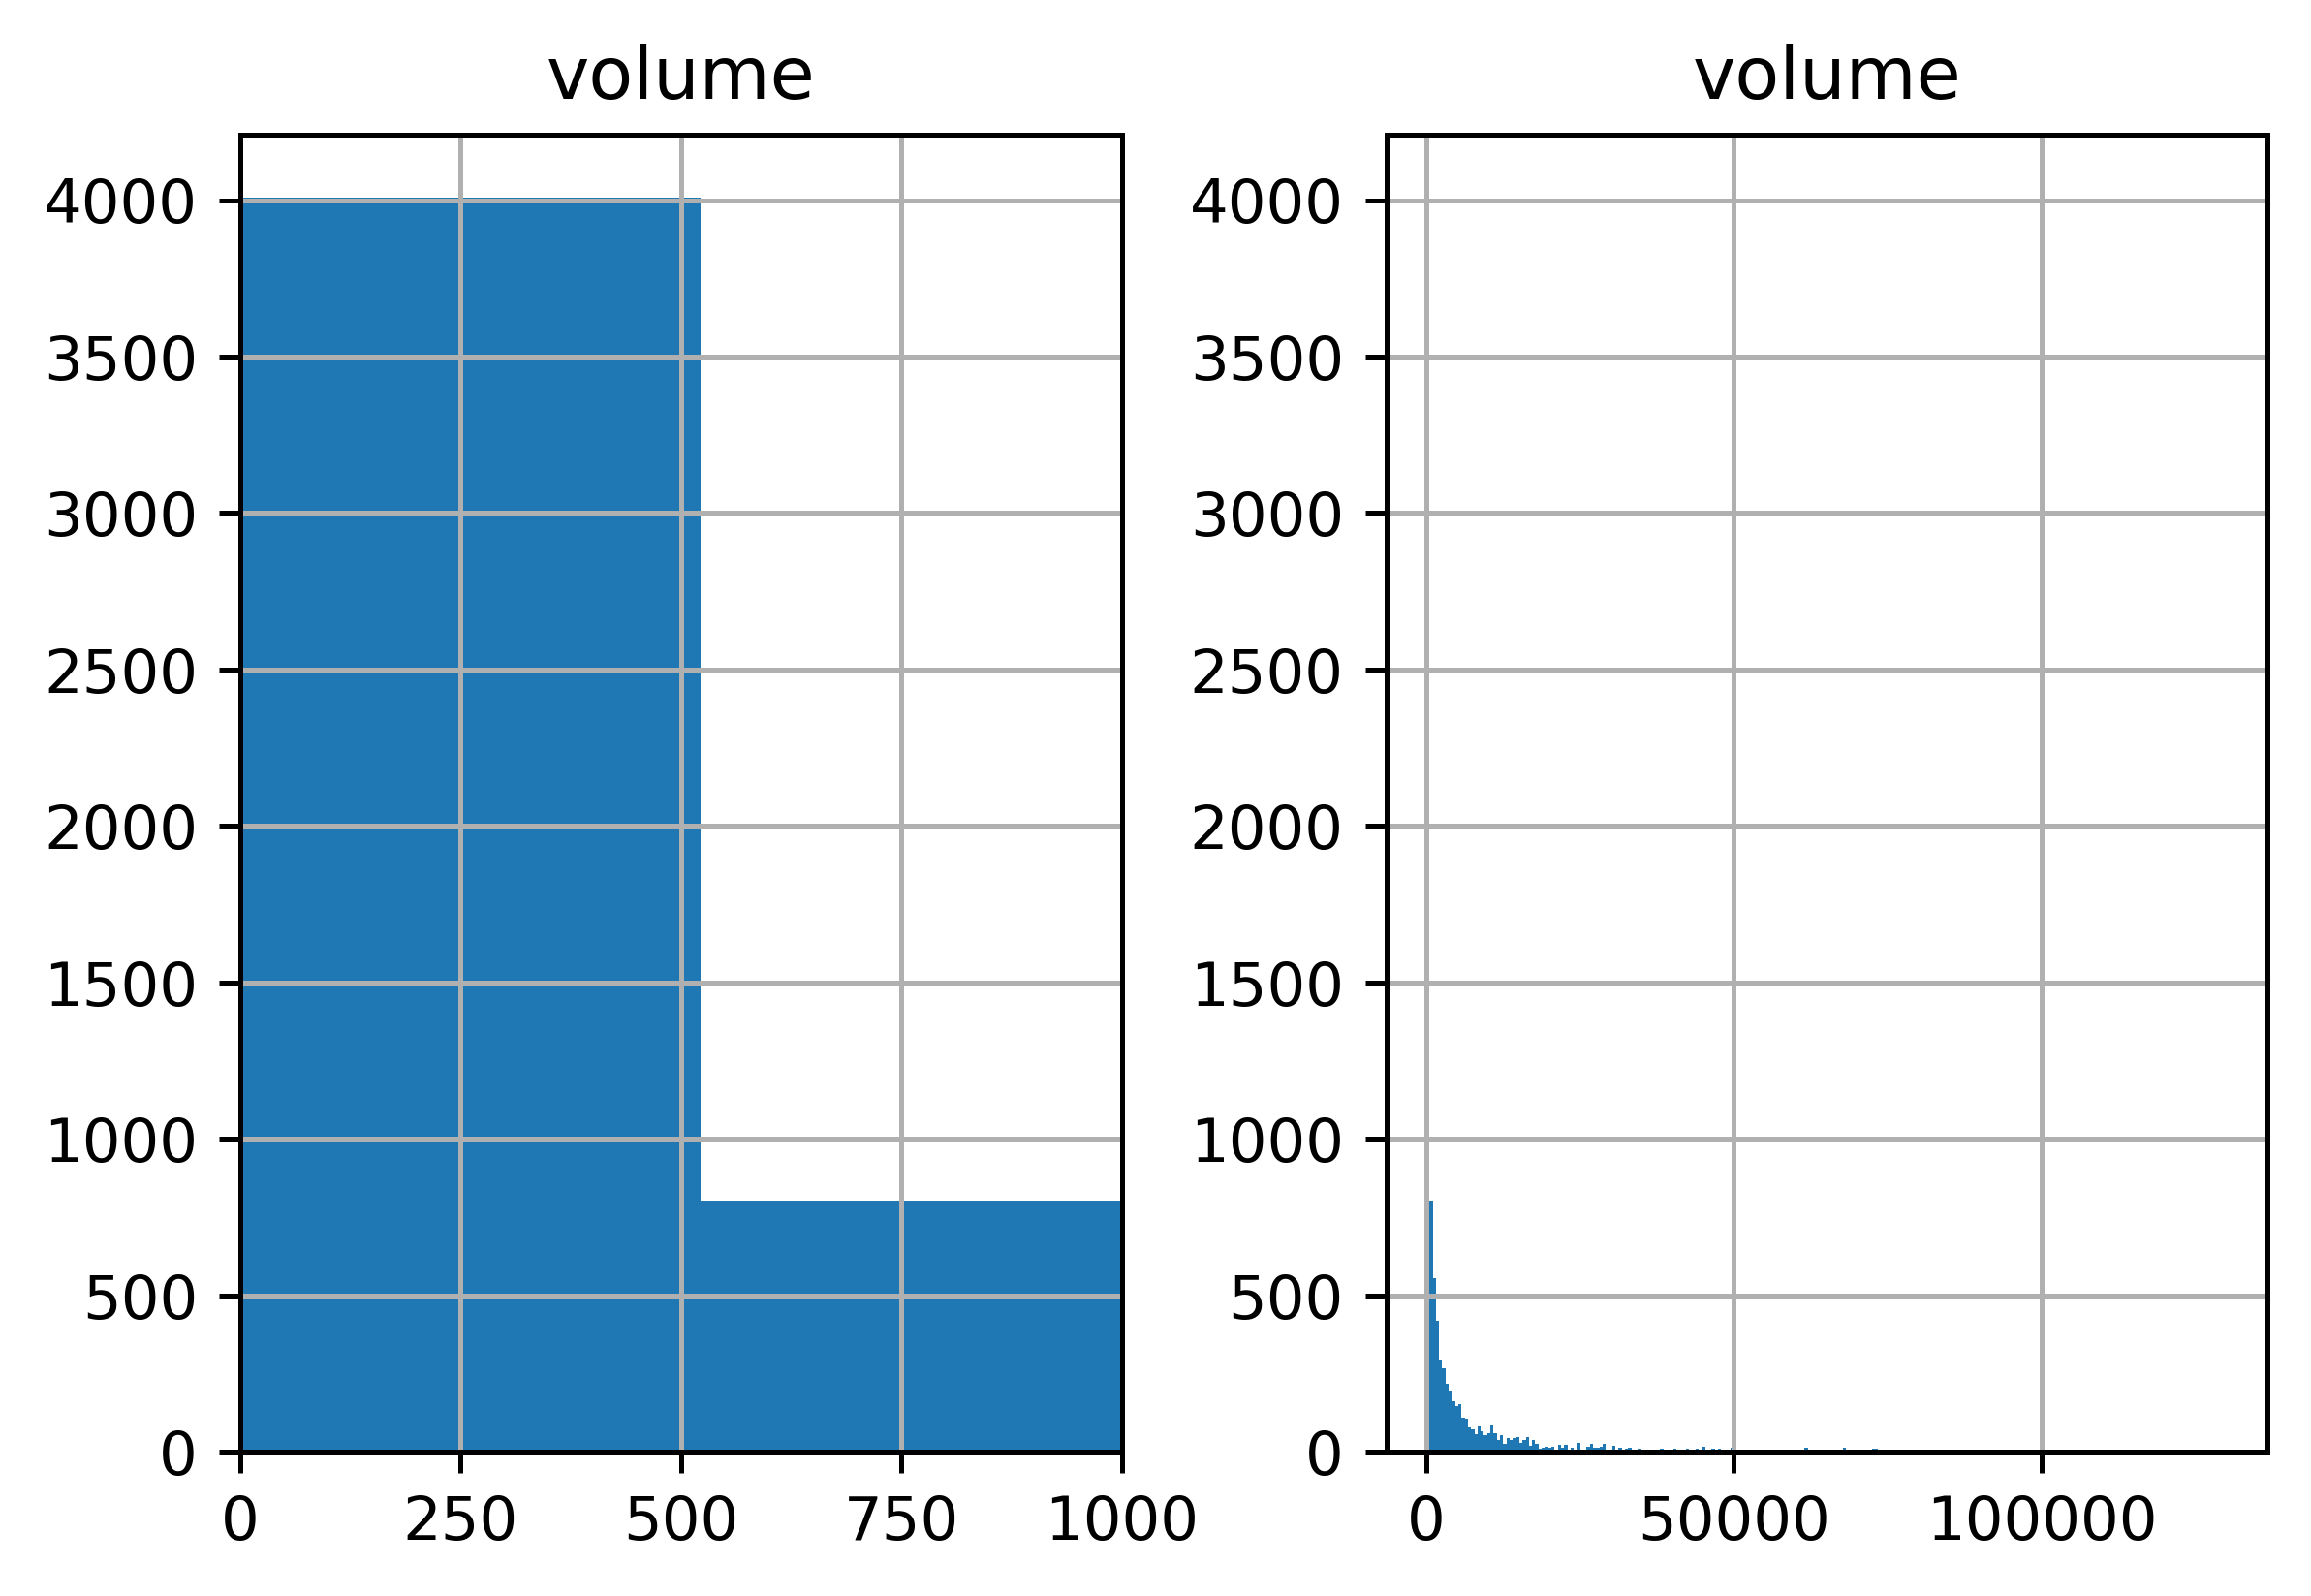

In [378]:
fig, (ax1, ax2) = plt.subplots(1,2)
centreline_counts.hist('volume', bins = 250, ax = ax1)
centreline_counts.hist('volume', bins = 250, ax = ax2)
ax1.set_xlim([0,1000])

This histogram that I created confirms that picutre. The right plot shows the entire histogram, while the left shows only the 0 to 1000 section. As a solution, lets only plot the top quartile of road segments.

In [379]:
centreline_counts['volume'].quantile([0.25,0.5,0.75])

0.25     132.0
0.50     954.5
0.75    5107.0
Name: volume, dtype: float64

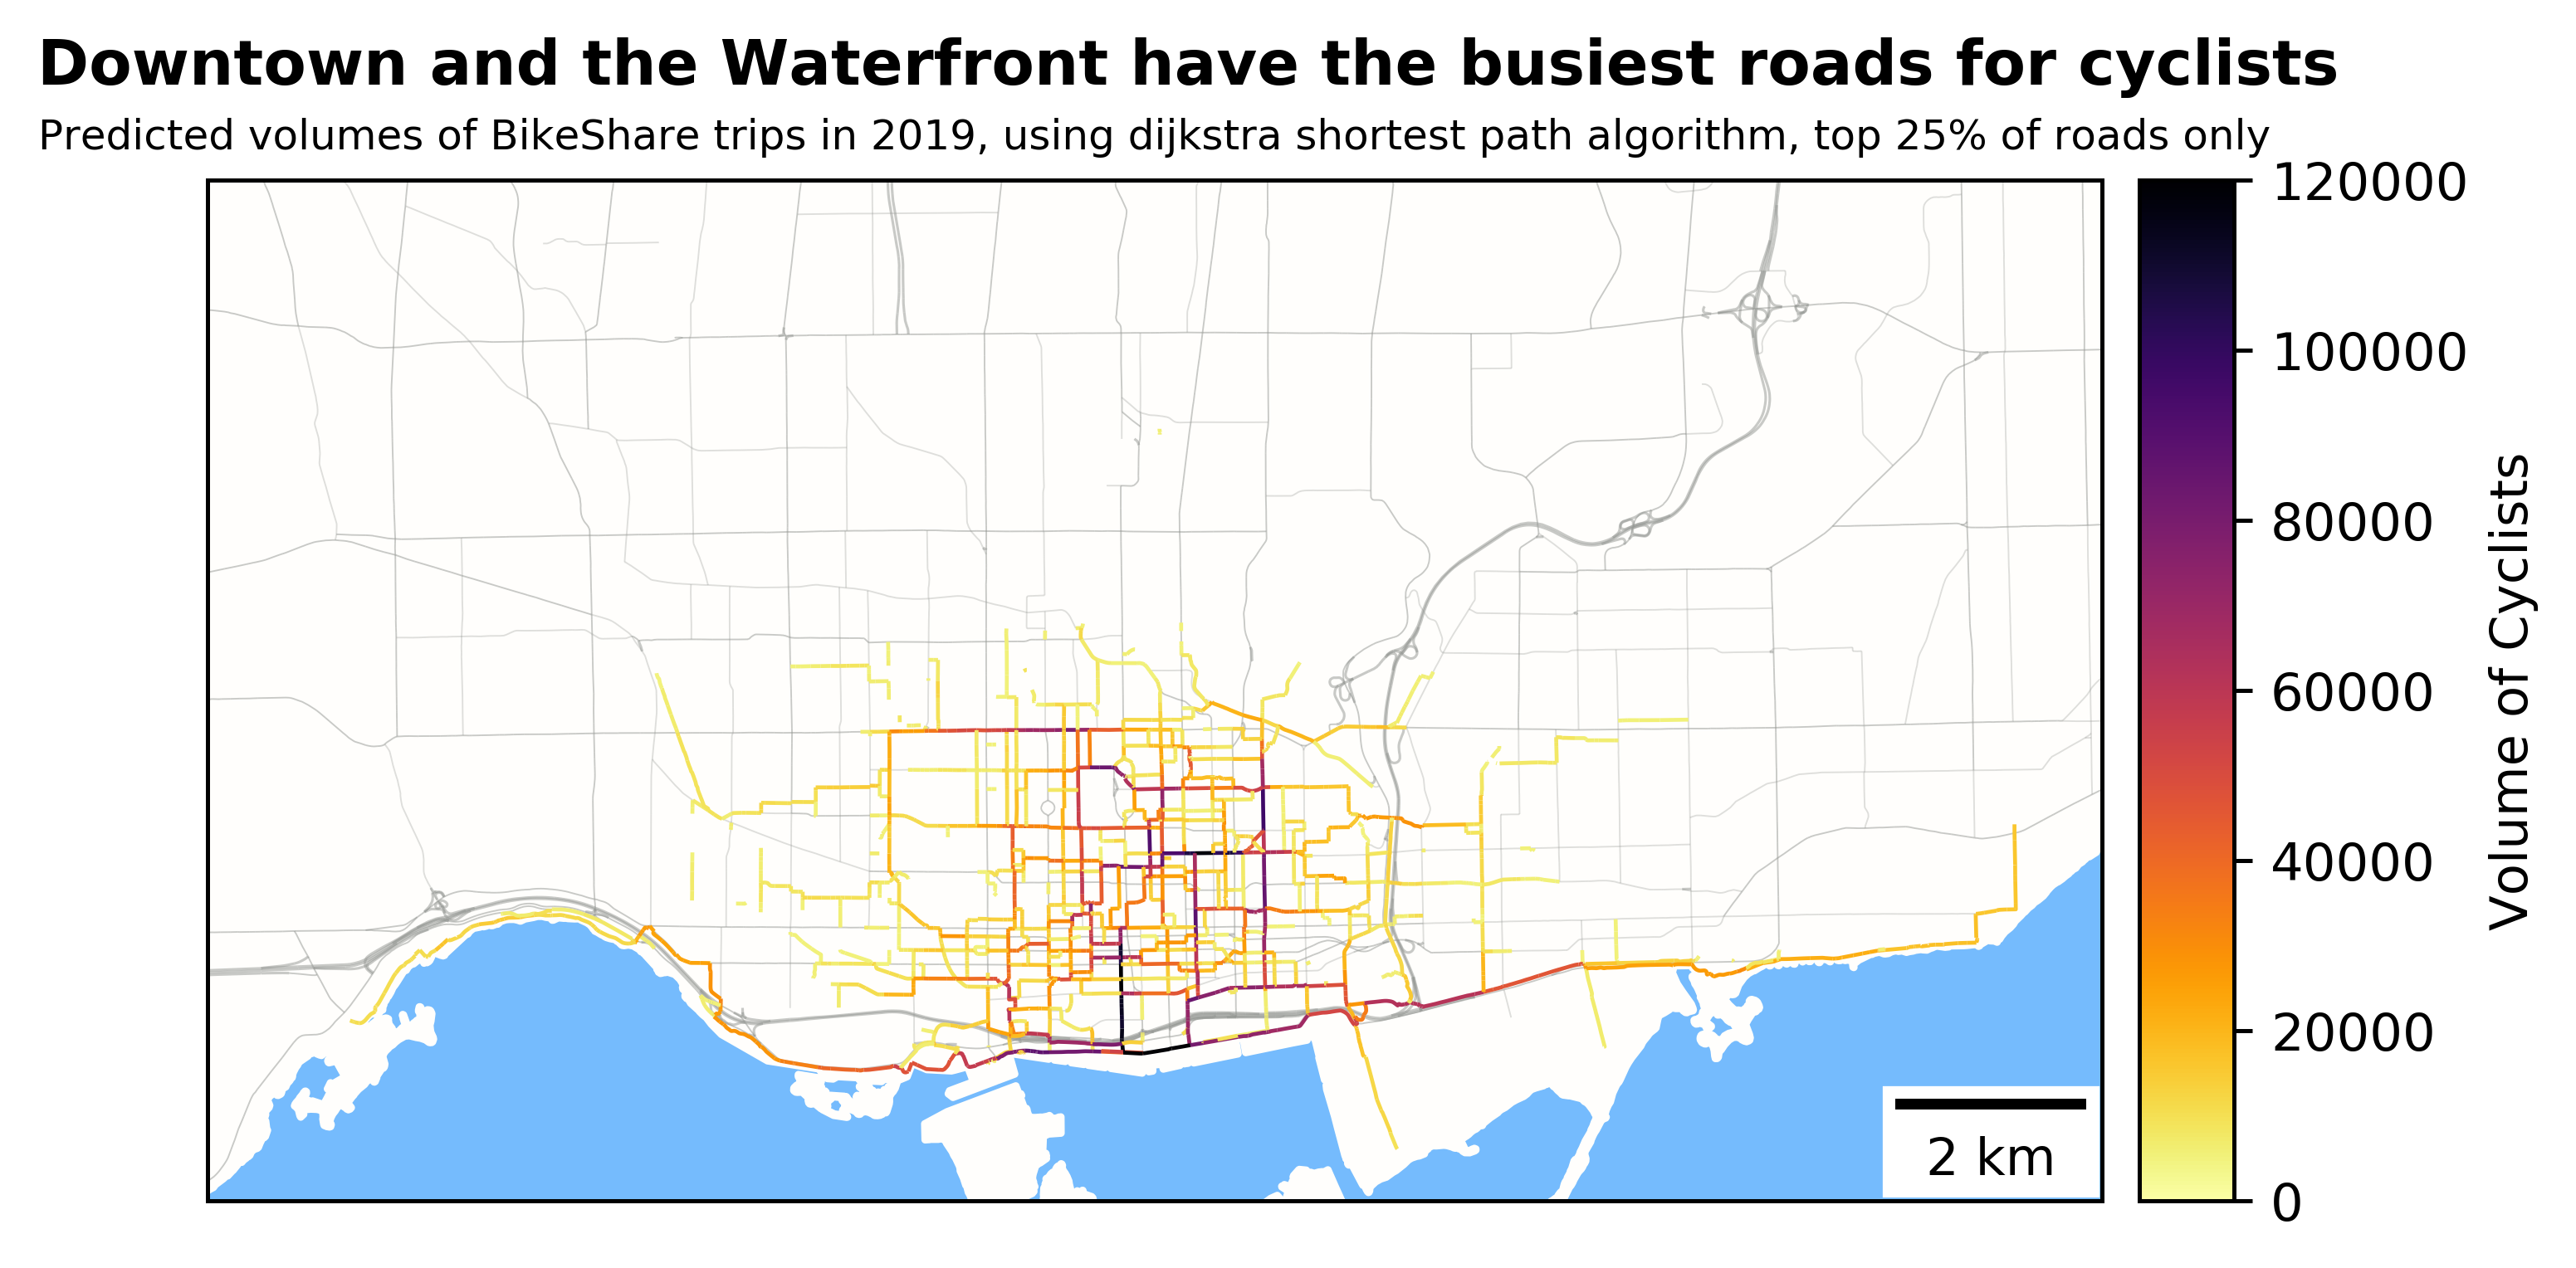

In [402]:
fig, ax = plt.subplots()
fig.set_size_inches(7,4)

divider = make_axes_locatable(ax) 

ax.set_facecolor('xkcd:sky blue')

cax = divider.append_axes("right", size="5%", pad=0.1) #to clean up the chloropleth legend

centreline[centreline['FCODE_DESC'].isin(['Expressway', 'Expressway Ramp', 'Major Arterial Ramp', 'Minor Arterial Ramp'])].plot(
    zorder = 1, color = 'xkcd:grey', ax = ax, linewidth = 0.5, alpha = 0.5)

centreline[centreline['FCODE_DESC'] == 'Major Arterial'].plot(zorder = 1, color = 'xkcd:grey', ax = ax, linewidth = 0.3, alpha = 0.5)
centreline[centreline['FCODE_DESC'] == 'Minor Arterial'].plot(zorder = 1, color = 'xkcd:grey', ax = ax, linewidth = 0.3, alpha = 0.3)



to_boundary.buffer(40).plot(zorder = 0, color = '#fffefc', ax = ax)
#to_boundary.plot(zorder = 0, color = 'w', ax = ax)

centreline_counts[centreline_counts['volume'] > 5107].plot(ax = ax, column = 'volume', cmap = 'inferno_r', 
                                                         legend = True, linewidth = 0.75, zorder = 2,
                     legend_kwds={'label': "Volume of Cyclists"}, cax = cax, vmin = 0, vmax = 120000)

plt.suptitle('Downtown and the Waterfront have the busiest roads for cyclists', fontsize = 12, fontweight = 'bold', y = 0.94)

ax.set_title('Predicted volumes of BikeShare trips in 2019, using dijkstra shortest path algorithm, top 25% of roads only', fontsize = 8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
#ax.set_axis_off()

ax.set_ylim(ylim)
ax.set_xlim(xlim)

ax.add_artist(ScaleBar(1, location = 'lower right', length_fraction = 0.25))# scale bar

That's a lot better. From the map, we can see that key bike lanes, such as Sherbourne, the Martin Goodman Trail, Simcoe, Bloor, Beverley/St George, Brunswick, and Hoskin/Harbord/Wellesley dominate the counts. Overall, like with the trips by neighbourhood map, bikeshare trips are concentrated downtown, with some activity spreading out along the waterfront.

There are some interesting notes. Some roads with no bike lanes, such as The Esplanade and Victoria Street have high ridership. Our process favours residential roads, so those roads acted as a by pass for users on Yonge and King, even if those residential roads have no levels of bike infrastructure.

Another note is the section of the Martin Goodman Trail by Roncy. Because we didn't consider elevation changes, it routed cyclists on the bridge over the Gardiner, however this doesn't match reality. This is likely also the case for why the Riverdale Bridge over the DVP has more activity than Dundas, Gerrard, or the Prince Edward Viaduct.

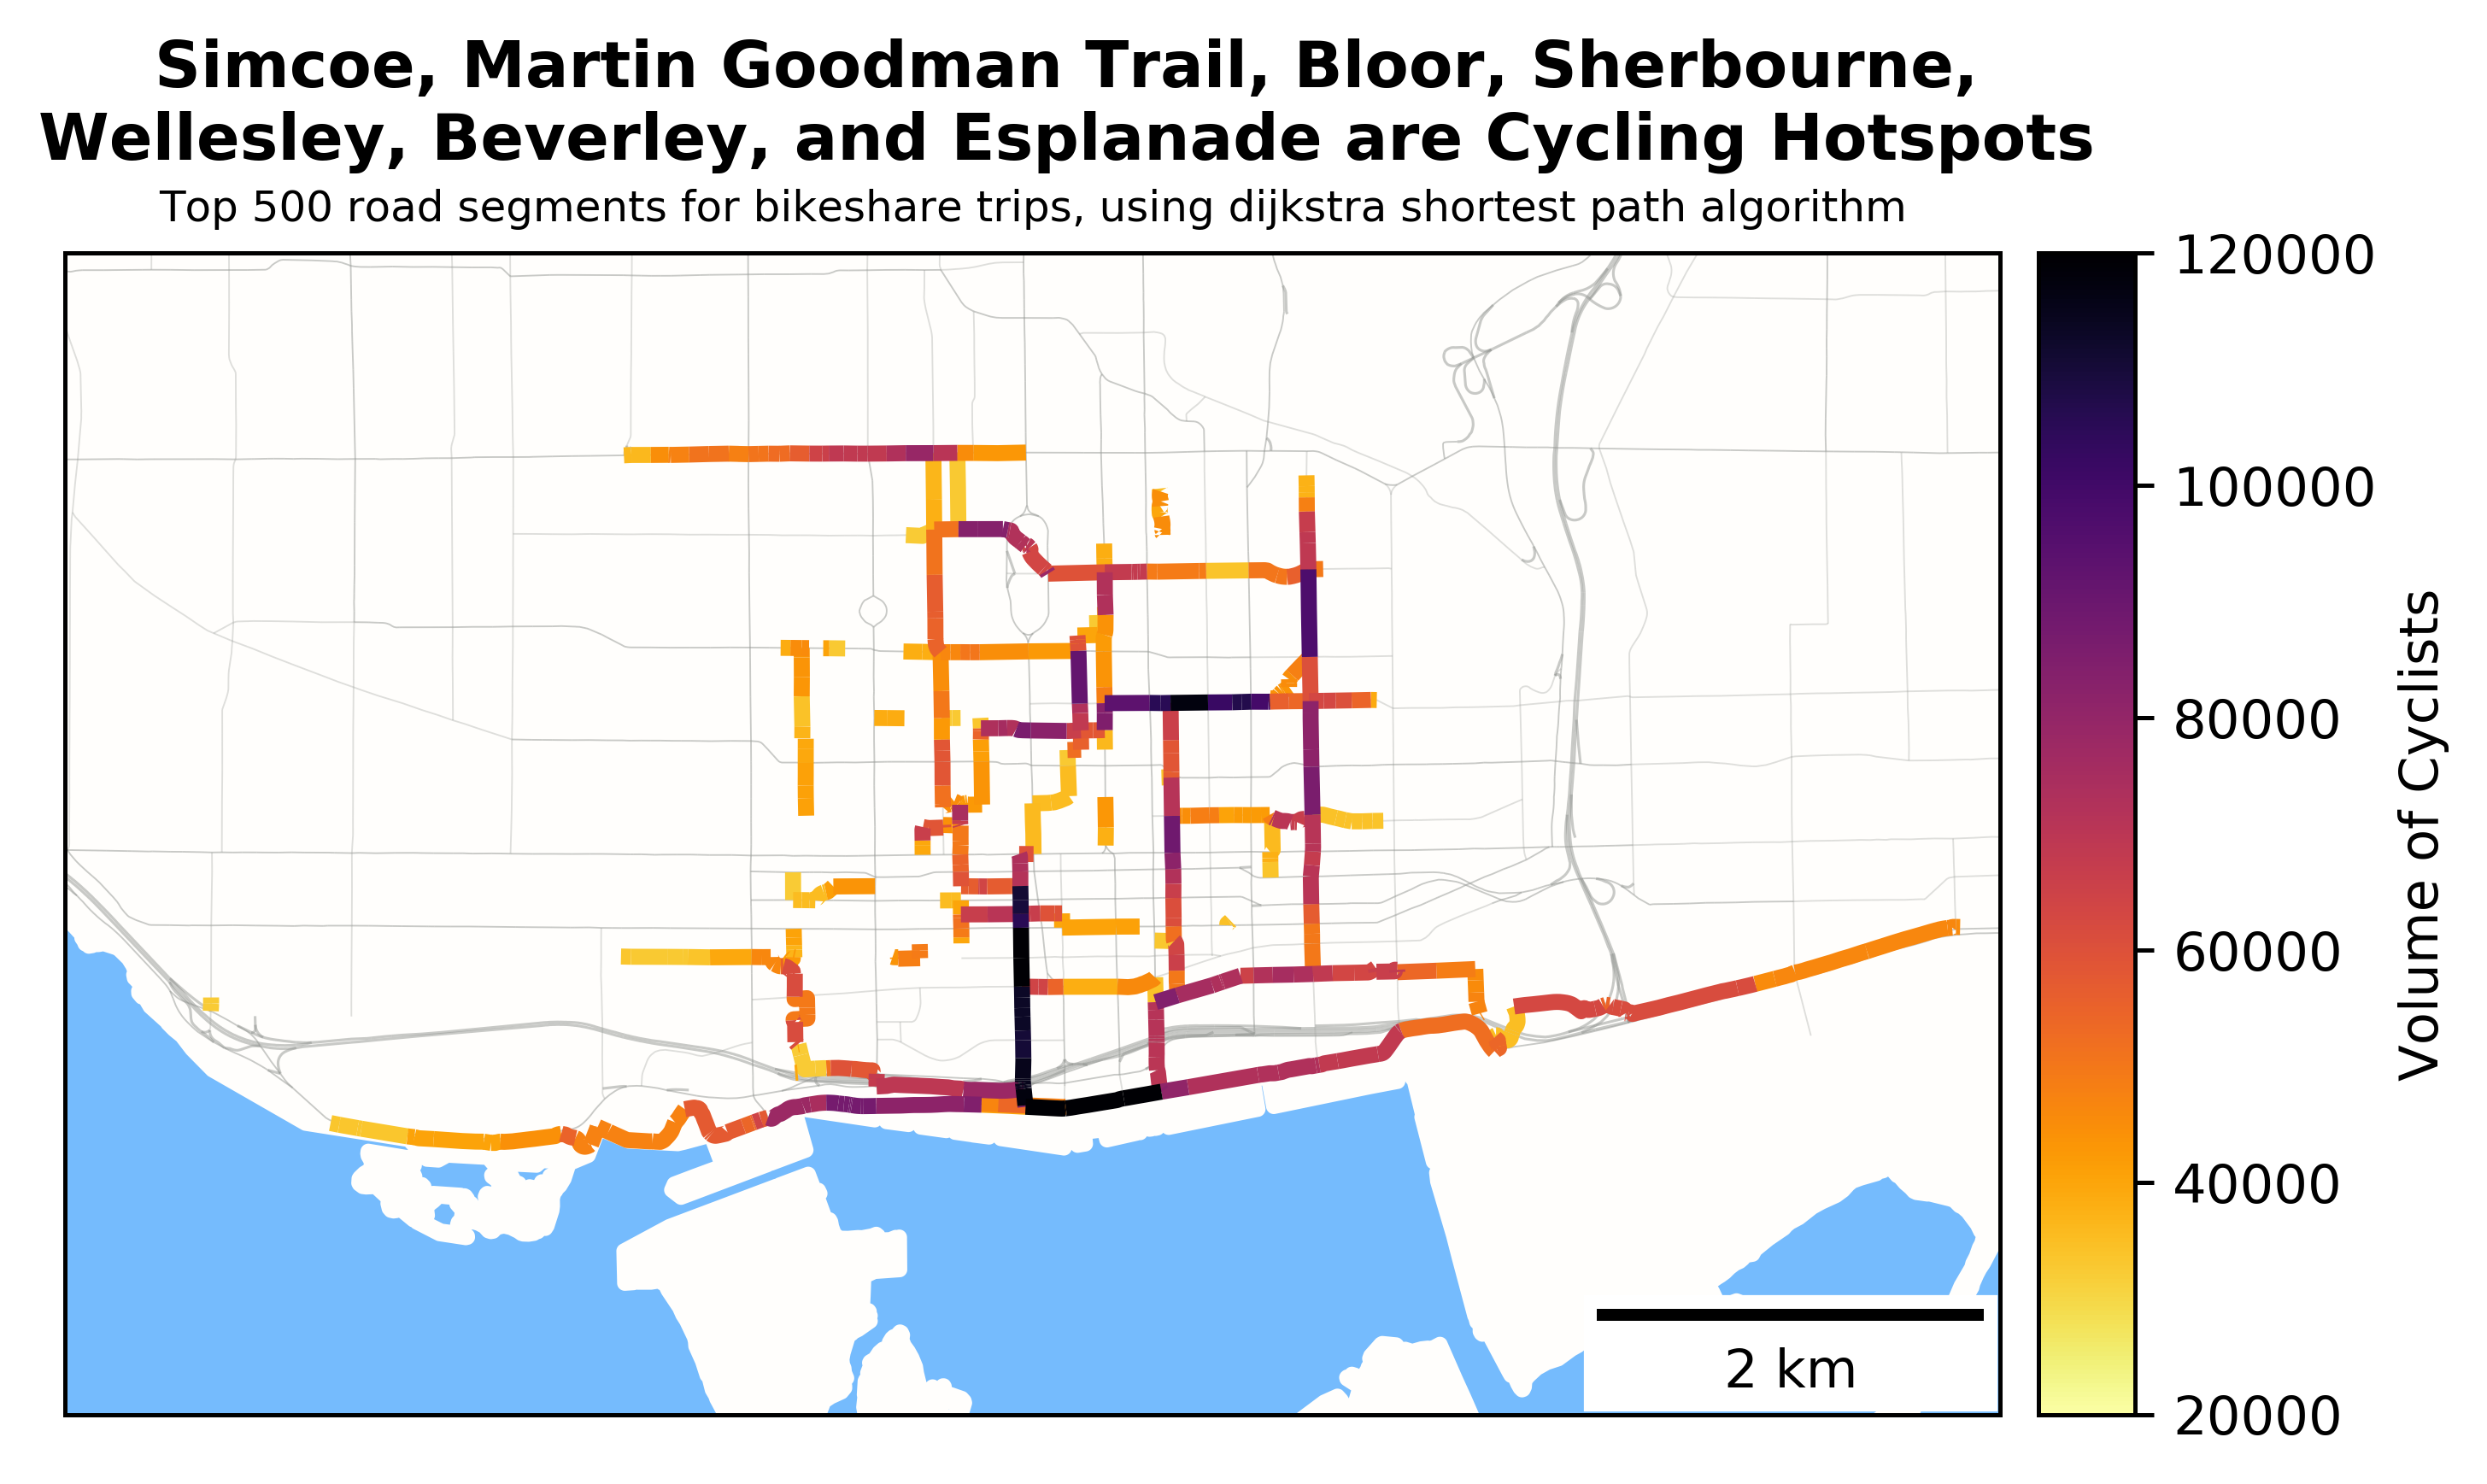

In [381]:
fig, ax = plt.subplots()
fig.set_size_inches(7,4)

divider = make_axes_locatable(ax) 

ax.set_facecolor('xkcd:sky blue')

cax = divider.append_axes("right", size="5%", pad=0.1)

centreline[centreline['FCODE_DESC'].isin(['Expressway', 'Expressway Ramp', 'Major Arterial Ramp', 'Minor Arterial Ramp'])].plot(
    zorder = 1, color = 'xkcd:grey', ax = ax, linewidth = 0.5, alpha = 0.5)

centreline[centreline['FCODE_DESC'] == 'Major Arterial'].plot(zorder = 1, color = 'xkcd:grey', ax = ax, linewidth = 0.3, alpha = 0.5)
centreline[centreline['FCODE_DESC'] == 'Minor Arterial'].plot(zorder = 1, color = 'xkcd:grey', ax = ax, linewidth = 0.3, alpha = 0.3)



to_boundary.buffer(40).plot(zorder = 0, color = '#fffefc', ax = ax)
#to_boundary.plot(zorder = 0, color = 'w', ax = ax)

top_500.plot(ax = ax, column = 'volume', cmap = 'inferno_r', 
                                                         legend = True, linewidth = 3, zorder = 2,
                     legend_kwds={'label': "Volume of Cyclists"}, cax = cax, vmin = 20000, vmax = 120000)


plt.suptitle('Simcoe, Martin Goodman Trail, Bloor, Sherbourne,\nWellesley, Beverley, and Esplanade are Cycling Hotspots', fontsize = 12, fontweight = 'bold', y = 1.02)

ax.set_title('Top 500 road segments for bikeshare trips, using dijkstra shortest path algorithm', fontsize = 8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
#ax.set_axis_off()

ax.set_ylim([4436000, 4442000])
ax.set_xlim([2011000,2021000])

ax.add_artist(ScaleBar(1, location = 'lower right', length_fraction = 0.25))# scale bar

The top 500 road segments confirms the map above, except we can clearly see the key corridors that have a lot of bike traffic. An obvious place for the city to create more bike infrastructure is to create another crossing under the Gardiner/Rail corridor, to relieve traffic on Simcoe (such as extending the Bay Street bike lanes). Another east downtown North South Bike lane may also be attractive since Sherbourne and Victoria streets are pretty busy. 

Anecdotally, the Queen's Quay section of the Martin Goodman Trail has always been the slowest and busiest section, and this map proces quantitatively that it may be worth looking into another way to relieve bike traffic around the ferry terminal.

### Analyzing the busiest corridor. 

We'll use another concept from transportation research called vehicles kilometers traveled, or VKT for short. We can't easily sum up the volumes that lie on the same street, but we can use VKT to account for distance when grouping road segments into road corridors.

VKT is simply the volume of cyclists a segment has multiplied by the length of that segment.

In [382]:
centreline_counts['vkt'] = centreline_counts['volume']*centreline_counts['length']/1000

This allows us to sum up te VKT grouped by road. Lets find out the top 10 corridors for bikeshare VKT.

In [383]:
road_top10 = centreline_counts.groupby('LF_NAME').sum()[['vkt']].sort_values(ascending = False, by = 'vkt').head(10)

In [384]:
road_top10 = road_top10.reset_index()

We'll also want to map the bike infrastructure to each road.

In [385]:
bikeways_unique = bikeways.sort_values(by = 'STREET_NAME')[['STREET_NAME', 'INFRA_HIGHORDER']].drop_duplicates(keep = 'first')

In [386]:
road_top10 = road_top10.merge(bikeways_unique, left_on = 'LF_NAME', right_on = 'STREET_NAME', how = 'left')

In [387]:
road_top10

LF_NAME            vkt          STREET_NAME  \
0         Martin Goodman Trl  530857.575617   Martin Goodman Trl   
1         Martin Goodman Trl  530857.575617   Martin Goodman Trl   
2              Sherbourne St  180834.041867        Sherbourne St   
3                 Bloor St W  144841.252692           Bloor St W   
4                 Bloor St W  144841.252692           Bloor St W   
5   Lake Shore Blvd East Trl  122054.158288                  NaN   
6               Gerrard St E  108276.610236         Gerrard St E   
7               Gerrard St E  108276.610236         Gerrard St E   
8                     Bay St  106530.909307               Bay St   
9                     Bay St  106530.909307               Bay St   
10                College St   89819.934335           College St   
11                College St   89819.934335           College St   
12       Lower Don River Trl   86950.221554  Lower Don River Trl   
13       Lower Don River Trl   86950.221554  Lower Don River Trl   
14               Victoria St   85219.877548                  NaN   
15             The Esplanade   83934.034067        The Esplanade   

                             INFRA_HIGHORDER  
0   MUT (2016 Network Plan/2012 Trails Plan)  
1                            Multi-Use Trail  
2                                Cycle Track  
3                        Sharrows - Arterial  
4                                Cycle Track  
5                                        NaN  
6                                  Bike Lane  
7                                Cycle Track  
8                        Sharrows - Arterial  
9                                  Bike Lane  
10                                 Bike Lane  
11                       Sharrows - Arterial  
12                           Multi-Use Trail  
13  MUT (2016 Network Plan/2012 Trails Plan)  
14                                       NaN  
15       Signed Route (No Pavement Markings)

Some roads have multiple levels of bike infrasturcture because of different segments. We'll manually choose the most appropriate, but for a more comprehensize analysis, we'll ideally want an automated process.

Similarly, we'll need to manually clean up the `INFRA_HIGHORDER` column.

In [388]:
road_top10['INFRA_HIGHORDER'] = np.where(road_top10['INFRA_HIGHORDER'] == 'MUT (2016 Network Plan/2012 Trails Plan)',
                                          'Multi-Use Trail', road_top10['INFRA_HIGHORDER'])
road_top10['INFRA_HIGHORDER'] = np.where(road_top10['INFRA_HIGHORDER'] == 'Contraflow Cycle Track',
                                          'Cycle Track', road_top10['INFRA_HIGHORDER'])
road_top10['INFRA_HIGHORDER'] = np.where(road_top10['INFRA_HIGHORDER'] == 'Sharrows - Arterial',
                                          np.nan, road_top10['INFRA_HIGHORDER'])
road_top10['INFRA_HIGHORDER'] = np.where(road_top10['LF_NAME'] == 'Yonge St',
                                          np.nan, road_top10['INFRA_HIGHORDER'])
road_top10['INFRA_HIGHORDER'] = np.where(road_top10['LF_NAME'] == 'Lake Shore Blvd East Trl',
                                          'Multi-Use Trail', road_top10['INFRA_HIGHORDER'])

In [389]:
road_top10 = road_top10.sort_values(by = 'INFRA_HIGHORDER').drop_duplicates(['LF_NAME', 'vkt'], keep = 'first'
                                                              ).sort_values(by = 'vkt', ascending = False)

In [390]:
road_top10['INFRA_HIGHORDER'] = road_top10['INFRA_HIGHORDER'].fillna('None') # so that we get a legend colour
road_top10 = road_top10.rename(columns = {'INFRA_HIGHORDER':'Bike Infrastructure'})

In [391]:
road_top10 

LF_NAME            vkt          STREET_NAME  \
0         Martin Goodman Trl  530857.575617   Martin Goodman Trl   
2              Sherbourne St  180834.041867        Sherbourne St   
4                 Bloor St W  144841.252692           Bloor St W   
5   Lake Shore Blvd East Trl  122054.158288                  NaN   
6               Gerrard St E  108276.610236         Gerrard St E   
9                     Bay St  106530.909307               Bay St   
10                College St   89819.934335           College St   
12       Lower Don River Trl   86950.221554  Lower Don River Trl   
14               Victoria St   85219.877548                  NaN   
15             The Esplanade   83934.034067        The Esplanade   

                    Bike Infrastructure  
0                       Multi-Use Trail  
2                           Cycle Track  
4                           Cycle Track  
5                       Multi-Use Trail  
6                             Bike Lane  
9                             Bike Lane  
10                            Bike Lane  
12                      Multi-Use Trail  
14                                 None  
15  Signed Route (No Pavement Markings)

In [405]:
centreline_counts['vkt'].sum()

4731319.432600401

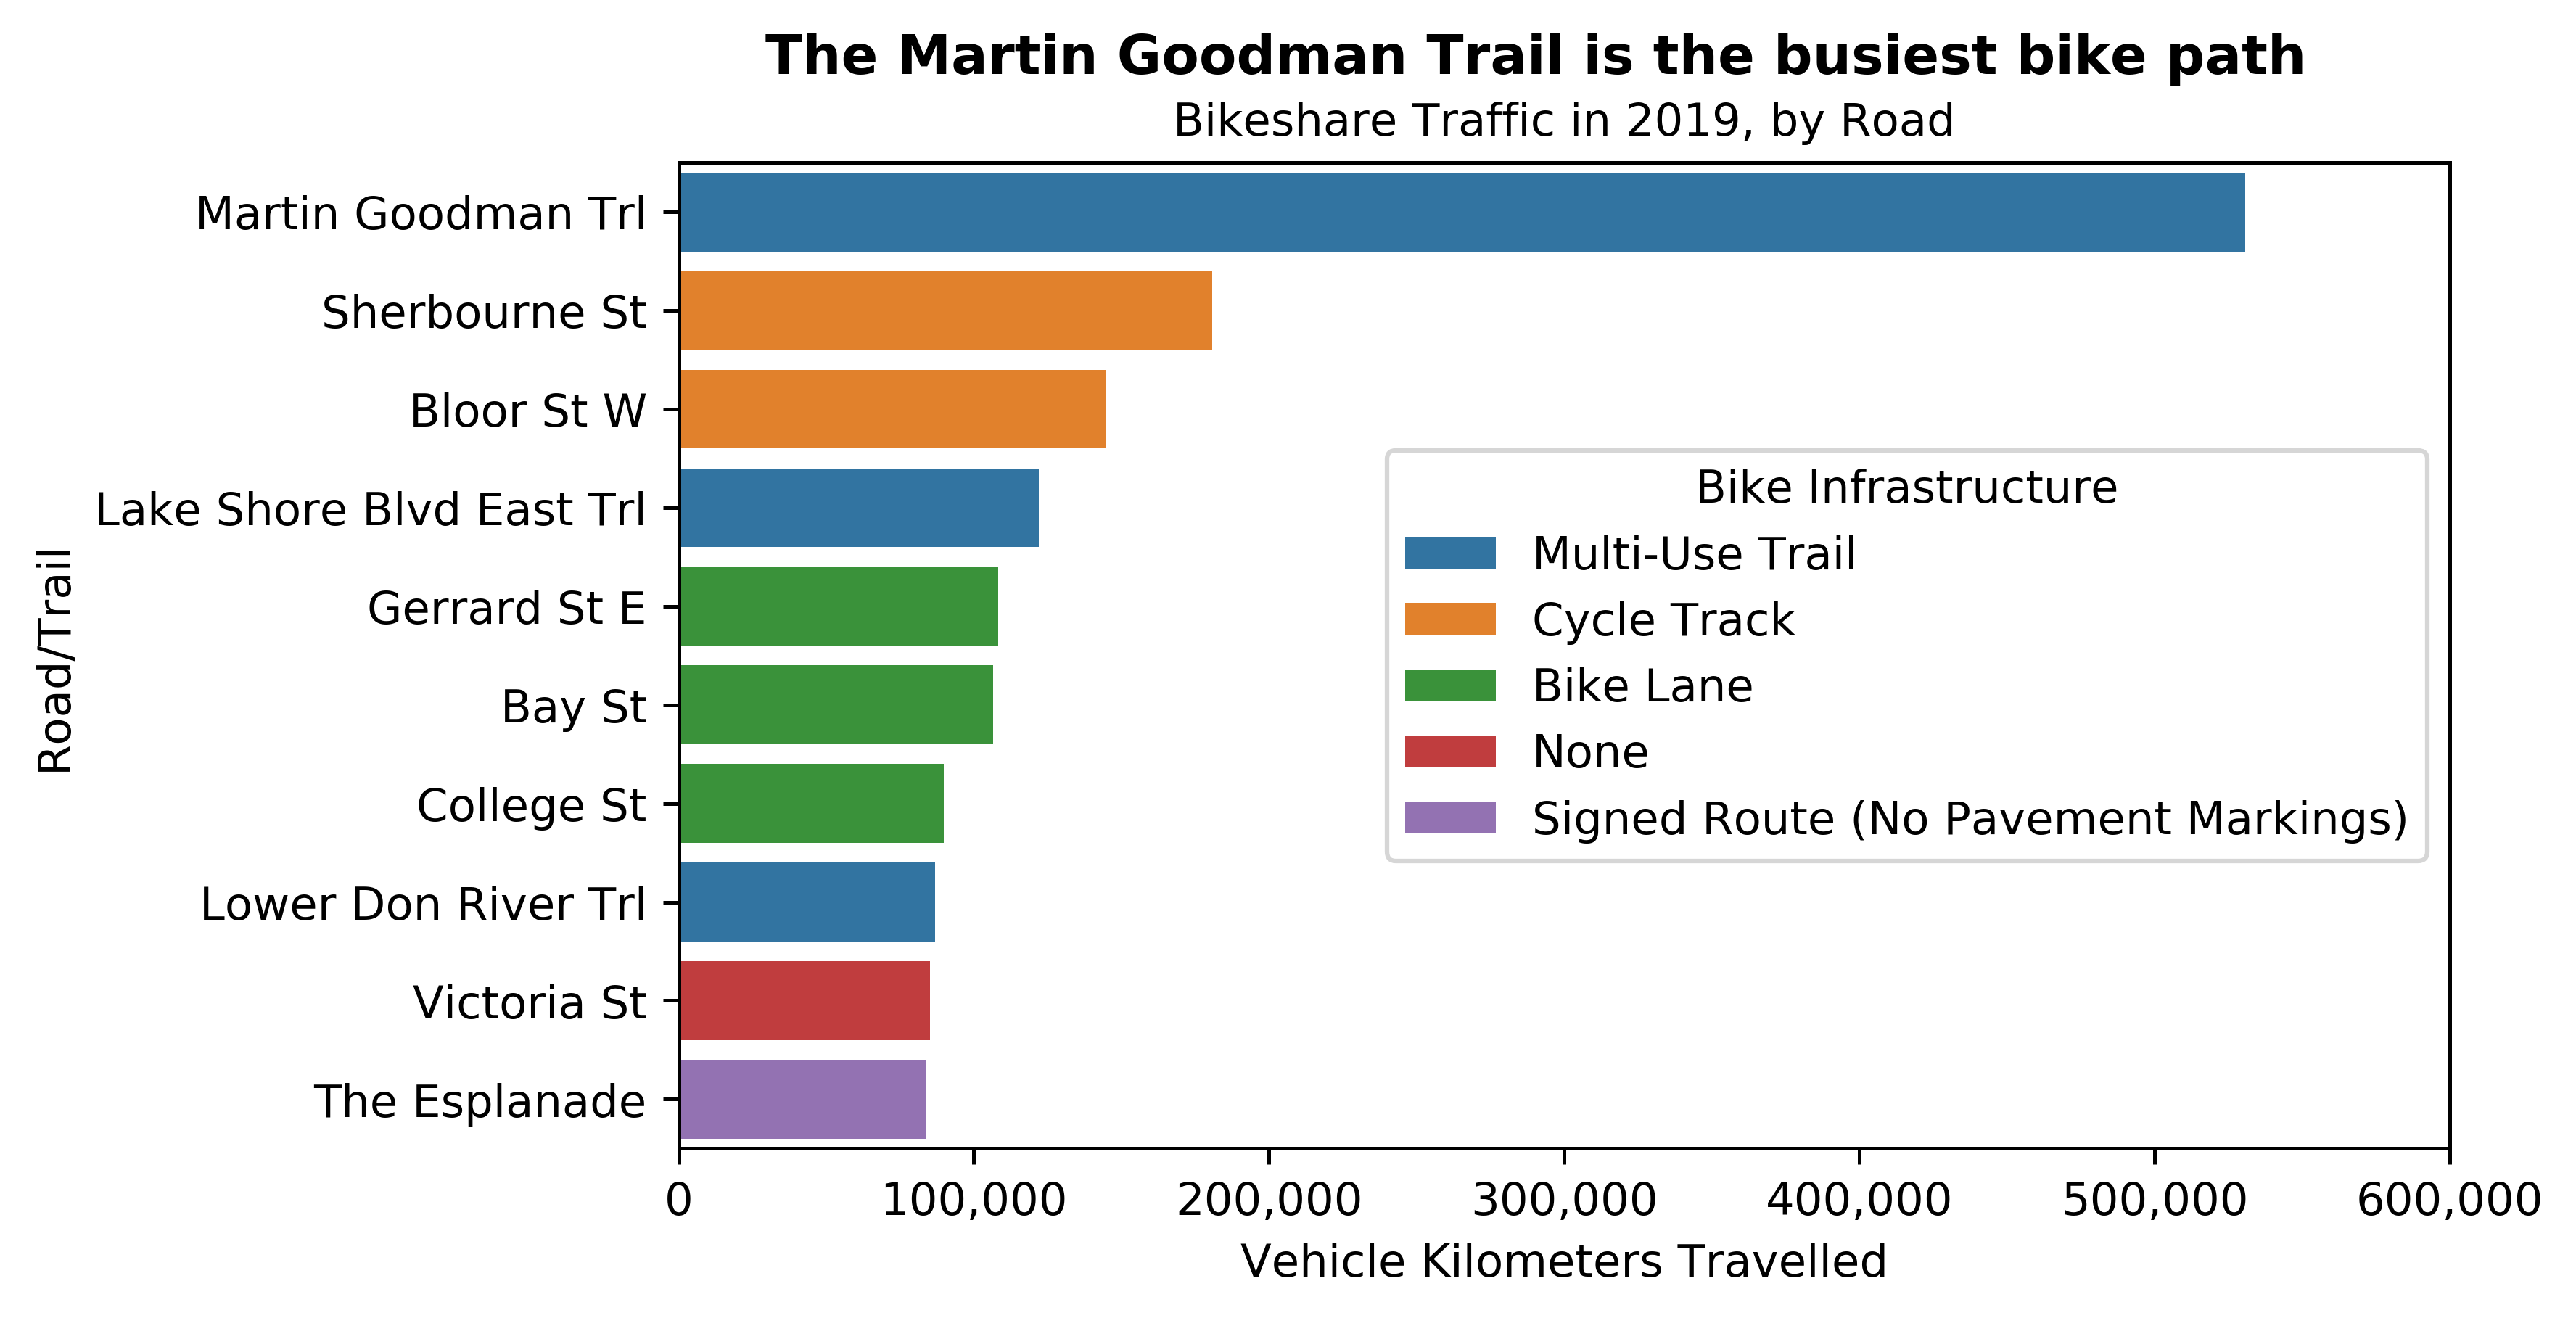

In [392]:
fig, ax = plt.subplots()

fig.set_size_inches(7,4)

sns.barplot(y = 'LF_NAME', x = 'vkt', data = road_top10, ax = ax, orient = 'h', hue = 'Bike Infrastructure', dodge = False)

ax.set_yticks(range(10))
ax.set_xticks(range(0,700000,100000))

ax.set_ylabel('Road/Trail')
ax.set_xlabel('Vehicle Kilometers Travelled')

ax.set_title('Bikeshare Traffic in 2019, by Road', fontsize = 10)
plt.suptitle('The Martin Goodman Trail is the busiest bike path', fontweight = 'bold', fontsize = 12)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_yticklabels(road_top10['LF_NAME'])

plt.show()

Its clear that the Martin Goodman Trail has high VKT and high traffic, and thats one of the main reasons why West End Toronto is number 2 on the busiest boroughs for Bikeshare riders. Having 11.2% of the total 4.7 million VKT in the city (or in other words, 11.2% of total bikeshare traffic), this shows that its one of the most important corridors in the city for east west travel.

Most of the other top corridors have some level of bike infrastructure with only Victoria Street and The Esplanade not having any (although The Esplanade was part of ActiveTO and is in the planning process to get permanent bikelanes). 

Its unclear how much riders are actually using Vicotria Street, as opposed to Yonge Street (due to the way we prioritized routes), but this does make the case for additional bike infrastructure in the yongeTOmorrow initative by the city.